# HR Churn - Eindwerk Data Science 2023-24 - Raf Ledeganck

<i>Functional presentation:
<ul>
<li><b>Privacy:</b> remove ID + name</li>
<li>Reduce no. of features = simplify (<b>increase transparency</b>) and generalize (<b>more value for society</b>) model.</li>
</ul>
</i>

## Imports

<i>(Development on Tensorflow 2.11.0 Docker Container)</i>

In [1]:
!pip install scikit-learn
#!pip install scikit-image
!pip install pandas
!pip install seaborn
#!pip install scikit-optimize
#!pip install imbalanced-learn
!pip install scikeras
!pip install feature_engine

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Sklearn
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, \
                            mutual_info_score, \
                            precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, mutual_info_regression
from sklearn.linear_model import LogisticRegression

In [4]:
# Scipy
from scipy import stats
from scipy.stats import chi2_contingency

In [5]:
# Tensorflow, Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
from scikeras.wrappers import KerasClassifier

In [7]:
from feature_engine.selection import DropConstantFeatures
from feature_engine.encoding import OrdinalEncoder

In [8]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#import sklearn
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder, StandardScaler
#from sklearn.decomposition import PCA
#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [9]:
from IPython.display import display_html 

In [13]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Program switches

In [14]:
# Grid search for feature selection
switch_pca_feat_sel = False   # Activate Principal Components
switch_rfc_feat_sel = False   # Activate grid search for Random Forest
switch_gb_feat_sel = False   # Activate grid search for Gradient Boosting

# Grid search for prediction models
switch_rfc_pred = False   # Activate grid search for Random Forest
switch_svm_pred = False   # Activate grid search for Support Vector Machines
switch_lr_pred = False   # Activate grid search for Logistic Regression
switch_nn_pred = False   # Activate grid search for Neural Network

switch_export_plots = True   # Activate export of plots as .jpg

## Functions

In [15]:
def fill_NaN_via_dupl(df, nan_cols=None, dup_colset=None, log=True):
    """
    1) Checks whether a row with a NaN value has duplicates by comparing it with similar rows.
    2) If all duplicate rows share the same value for the column with NaN, then the NaN is replaced with this value.

    Parameters
    ----------
    df: DataFrame
        Dataframe in which NaN values are to be replaced.
    nan_cols: list
        List of columns in which we want to replace the NaN
        Example: ['EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL']
    dup_colset: list
        List of columns used to derive a fill value for the NaN
        If a row has a NaN value in a specified column, the function checks for similar rows by comparing the values in this
        column set.  If all columns in this set have an identical value to the row with NaN, then the rows are considered
        'similar'.
        Example: ['EMPLOYEE_TYPE', 'DEPARTMENT', 'JOB', 'COMPANY', 'SITE', 'PERMANENT', 'EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL']
    log: boolean
        Activate output of log

    Return
    ------
    df_stats: DataFrame
        Statistics on the performance of the function
        - 'col': column name
        - 'nan': no. of lines with NaN
        - 'fill': no. of NaN replaced with value from similar lines
        - 'mult': no. of NaN lines not filled because similar lines have multiple values and look-up is inconclusive
        - 'nodup': no. of NaN lines not filled because there are no similar lines to derive a replacement value from

    """
    
    if nan_cols == None:
        nan_cols = ['EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL']
    if dup_colset == None:
        dup_colset = ['EMPLOYEE_TYPE', 'DEPARTMENT', 'JOB', 'COMPANY', 'SITE', 'PERMANENT', 'EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL']
    
    if log:
        print("Value counts before clean-up:")
        for col in nan_cols:
            print(df[col].value_counts(dropna=False), "\n")

    col_lst, nan_lst, fill_lst, mult_lst, nodup_lst = list(), list(), list(), list(), list()
    
    # Function assumes NAN_COLS is a subset of DUP_COLSET.  If this is not the case, it is enforced here.
    dup_colset = dup_colset + nan_cols
    dup_colset = np.unique(dup_colset).tolist()

    # Look-up takes 10 columns as input.  If less than 10 columns were given, add empty ones.
    df_subset = df[dup_colset].copy()
    i = len(df_subset.columns)
    if i > 11:
        raise Exception("Max. 10 columns can be used to find similar rows.")
    while i < 11:
        i += 1
        col_name = 'EMPTY' + str(i)
        df_subset[col_name] = "0"
        dup_colset.append(col_name)
        
    for col in nan_cols:
        count_nan = 0
        count_fill = 0
        count_mult = 0
        count_nodup = 0
        dup_cols = dup_colset.copy()
        dup_cols.remove(col)

        # Build a Series which indicates for each line in DF whether it has a duplicate row 
        # considering all columns except COL
        ser_dup = df_subset.duplicated(subset=dup_cols, keep=False)

        # Build a list with the index of all rows in DF that have NaN for COL
        lst_na = df_subset.loc[pd.isna(df[col]), :].index

        for i in lst_na:
            count_nan += 1

            # For each row where COL == NaN, check if it has a duplicate
            if ser_dup.iloc[i] == True:

                # Row has duplicate.
                # SEARCH_LINE is the row for which we aim to remove the NaN
                search_line = df_subset.iloc[i, :]

                # Build dataframe with all duplicate lines for SEARCH_LINE ignoring COL
                df_dup = df_subset.loc[(df_subset[dup_cols[0]] == search_line[dup_cols[0]]) &   
                                       (df_subset[dup_cols[1]] == search_line[dup_cols[1]]) &
                                       (df_subset[dup_cols[2]] == search_line[dup_cols[2]]) &
                                       (df_subset[dup_cols[3]] == search_line[dup_cols[3]]) &
                                       (df_subset[dup_cols[4]] == search_line[dup_cols[4]]) &
                                       (df_subset[dup_cols[5]] == search_line[dup_cols[5]]) &
                                       (df_subset[dup_cols[6]] == search_line[dup_cols[6]]) &
                                       (df_subset[dup_cols[7]] == search_line[dup_cols[7]]) &
                                       (df_subset[dup_cols[8]] == search_line[dup_cols[8]]) &
                                       (df_subset[dup_cols[9]] == search_line[dup_cols[9]])
                                        ]

                # Check if all lines in DF_DUP have same value in COL, if so we assume we can replace NaN with this value
                if len(df_dup[col].value_counts()) == 1:
                    # All duplicate lines have the same value for the NaN field so we replace NaN with this value
                    df.iloc[i, df.columns.tolist().index(col)] = \
                                      df_dup[df_dup[col].notna()].iloc[0, df_subset.columns.tolist().index(col)]
                    count_fill += 1
                else:
                    # Multiple values for the NaN field, result is inconclusive, NaN is left
                    count_mult += 1     

            else:
                # No duplicate row for SEARCH_LINE, NaN is left
                count_nodup += 1

        col_lst.append(col)
        nan_lst.append(count_nan)
        fill_lst.append(count_fill)
        mult_lst.append(count_mult)
        nodup_lst.append(count_nodup)
    
    stats = {'col' : col_lst,
             'nan' : nan_lst,
             'fill' : fill_lst,
             'mult' : mult_lst,
             'nodup' : nodup_lst
            }
        
    if log:
        print("Value counts after clean-up:")
        for col in nan_cols:
            print(df[col].value_counts(dropna=False), "\n")

    return pd.DataFrame.from_dict(stats)


In [16]:
def agg_feat_imp(df_feat_imp):
    """
    Aggregate features (to undo OneHotEncoding)
    Only relevant for master data features (since these are the only encoded ones)

    Parameters
    ----------
    df_feat_imp: DataFrame
                 Dataframe with one-hot encoded features.

    Return
    ------
    df_abs: DataFrame
            Aggregated feature importances
            
    """

    df_abs = df_feat_imp.abs().copy()

    # Calculate total correlation per feature rather than by OneHotEncoder split
    for row in master_data_cols:
        prefix = 'cat__' + row

        # Add row with total correlation
        df_abs.loc[row] = df_abs.filter(regex=prefix, axis='index').sum().values[0]

        # Remove rows with correlations for individual OneHotEncoder splits
        df_abs.drop(list(df_abs[df_abs.index.str.startswith(prefix)].index), axis='index', inplace=True)

    # Remove prefixes from row names
    dict_rownames = {}
    for row in df_abs.index:
        if row.find('__') > 0:
            dict_rownames[row] = row[ (row.find('__')+2) : ]

    df_abs.rename(index=dict_rownames, inplace=True)

    return(df_abs)

In [17]:
def chi2(df, feat_col=None, target_col='Target_Churn', threshold=0.05):
    """
    Chi squared correlation test for features in list 'feat_col' regarding the target specified by 'target_col'.

    Parameters
    ----------
    df: DataFrame
        Dataframe with features and target for which the test has to be executed.
    feat_col: List
              Names of the feature columns in dataframe 'df'
    target_col: String
                Name of the target column in dataframe 'df'
    threshold: Float
               Threshold value for 'p' to accept/reject the null hypothesis

    Return
    ------
    stats: DataFrame
           For each feature (column), the p-value of the chi squared test, 
           and the result re. whether the feature is correlated with the target or not.
           
    """

    if feat_col == None:
        feat_col = df.columns.tolist()
        dup_cols.remove(target_col)

    col_lst, p_lst, corr_lst = list(), list(), list()
        
    for col in feat_col:
        ct = pd.crosstab(index=df[col],columns=df[target_col])
        chi2 = chi2_contingency(ct,)
        p, x = chi2[1], True if chi2[1] < threshold else False

        col_lst.append(col)
        p_lst.append(p)
        corr_lst.append(x)

    stats = {'col' : col_lst,
             'p' : p_lst,
             'correlated' : corr_lst
            }
    return pd.DataFrame.from_dict(stats)


In [18]:
def plot_feat_imp(df_feat_imp, sort_col='Importance', export=False, file_name='plot.jpg', show=True):
    """
    Generate bar plot of the feature importances, sorted from high to low.

    Parameters
    ----------
    df_feat_imp: DataFrame
                 Dataframe with the feature importances to be plotted
    sort_col: String
              Name of the column in dataframe 'df_feat_imp' which is the subject of the plot
    export: Boolean
            Export plot or not
    file_name: String
               Name of the file (incl. path, if different from working directory)
    show: Boolean
          Output plot to screen or not.

    Return
    ------
    n/a

    """

    # Sort from high to low importance
    df_feat_imp.sort_values(sort_col, ascending=False, inplace=True)

    # Generate plot
    fig, ax = plt.subplots(figsize=(12,6),dpi=100)
    sns.barplot(df_feat_imp, x=df_feat_imp.index, y=df_feat_imp[sort_col])
    plt.xticks(rotation=90)

    # Export plot
    if export:
        plt.savefig(file_name, bbox_inches='tight')

    # Print plot
    if show:
        plt.show()
    
    plt.close(fig);

In [19]:
def plot_feat_comp(df_full, df_red, sort_col='Importance', export=False, file_name='plot.jpg', show=True):
    """
    Generate double bar plot of the feature importances, sorted from high to low.
    Importances of 2 runs are compared.

    Parameters
    ----------
    df_full: DataFrame
             Dataframe with the feature importances of run 1 to be plotted.
    df_red: DataFrame
            Dataframe with the feature importances of run 2 to be plotted.
            This dataframe is assumed to be a subset of dataframe 'df_full'.
            Note: 'red' = 'reduced'
    sort_col: String
              Name of the column in dataframe 'df_feat_imp' which is the subject of the plot
    export: Boolean
            Export plot or not
    file_name: String
               Name of the file (incl. path, if different from working directory)
    show: Boolean
          Output plot to screen or not.

    Return
    ------
    n/a

    """

    # Sort feature importances from high to low
    # First sort reduced features
    df_red.sort_values(by='Importance', ascending=False, inplace=True)

    # Sort all features identically to reduced features
    # and append dropped features at the end (for easy comparison)
    df_tmp = df_red.copy()
    for row in df_tmp.index:
        df_tmp.loc[row] = df_full.loc[row].values[0]
        df_full.drop(row, axis='index', inplace=True)

    df_full.sort_values(by='Importance', ascending=False, inplace=True)

    df_full = pd.concat([df_tmp, df_full])

    # Add empty lines to dataframe with results for reduced feature set 
    # so the plots align vertically.
    i = len(df_tmp)
    while i < len(df_full):
        i += 1
        index_dummy = str('dummy_' + str(i))
        df_red.loc[i] = {index_dummy : 0}

    del df_tmp

    #rfc_feat_imp = pd.merge(left=rfc_feat_imp_X, right=rfc_feat_imp_Z, how='left')
    rfc_feat_imp = df_full.copy()
    rfc_feat_imp['Reduced set'] = df_red['Importance']
    rfc_feat_imp.rename(columns={'Importance' : 'All features'}, inplace=True)

    # Generate plot
    fig, ax = plt.subplots(figsize = (20, 8),
                           dpi = 100)
    rfc_feat_imp.plot.bar(ax = ax,
                          title='Feature importance comparison'
                         )

    annot = np.around(rfc_feat_imp['All features'].values, 4)
    ax.bar_label(ax.containers[0], 
                 labels=annot, 
                 label_type='edge',
                 padding=5,
                 rotation=90,
                 size=9)
    ax.set_xlabel("Features")
    ax.set_ylabel("Feature importance")

    plt.axvline(x = 31.5, ls='dotted', color = 'grey', label = 'Reduced/full feature set')

    plt.legend()
    min_y, max_y = plt.ylim()
    max_y = max_y * 1.1
    plt.ylim(min_y, max_y)
    plt.show();

In [20]:
def col_trans(X=None, cat_feat=None, num_feat=None):
    """
    Transform dataframe 'X' to 'scaled_X' so it can be used as input for a model.
    Categorical features are one-hot encoded.
    Numerical features are scaled.
    Features of other types are left unchanged.
    
    Parameters
    ----------
    X: DataFrame
       Dataframe to be scaled, one-hot encoded.
    cat_feat: List
              Names of categorical features.
    num_feat: List
              Names of numerical features.

    Return
    ------
    scaled_X:    Numpy array
                 Categorical variables (= list 'cat_feat') are one-hot encoded.
                 Features in list num_feat are scaled with Standard Scaler.
                 Other features (e.g. numerical master data) are left unchanged.
    df_scaled_X: DataFrame of scaled_X
    transformer: Can be used to transform another dataset based on the fit of this function.             

    """

    scaler = StandardScaler()

    transformer = ColumnTransformer(
        [
            ('cat', OneHotEncoder(drop='if_binary', sparse_output=False, dtype=np.intc), cat_feat),
            ('num', StandardScaler(), num_feat),
        ], remainder='passthrough'   # By default, all un-transformed columns are dropped.
    )
    
    scaled_X = transformer.fit_transform(X)

    df_scaled_X = pd.DataFrame(data=scaled_X, columns=transformer.get_feature_names_out())
    
    return scaled_X, df_scaled_X, transformer

In [21]:
def del_nan(df, cols=None, threshold_perc=2, log=True):
    """
    Transform dataframe 'X' to 'scaled_X' so it can be used as input for a model.
    
    Parameters
    ----------
    df: DataFrame
        Dataframe in which NaN values are to be replaced.
    cols: List
          Names of the columns in dataframe 'df' that are checked for NaN
    threshold_perc: Float (interpreted as a percentage, '1' = 1%)
                    Safety: Error is raised when the function would remove more lines than the specified percentage.
    log: Boolean
         If True, f-string with % of lines dropped is printed.

    Return
    ------
    df: DataFrame
        Dataframe 'df' but with the NaN-lines removed.     

    """
    
    count = 0

    # Count no. of lines with NaN.
    # Potentially lines are counted double if multiple NaN on same row, but then we're just being over-cautious.
    for col in cols:
        count += df[col].isna().sum()

    # Calculate % of lines that would be dropped
    perc_nan = round( ( count / len(df) ) *100, 2)

    # Drop lines if less < specified threshold of the data would be impacted.
    # Otherwise NaN need to be handled manually (-> error).
    count = 0

    if perc_nan < threshold_perc:
        start_point = len(df)
        for col in cols:
            df.dropna(subset=[col], inplace=True)
    else:
        raise Exception(f"Data contains too many NaN (>{threshold_perc}%) to be handled automatically.")

    perc_del = round( ( (start_point - len(df)) / start_point ) *100, 2)
    
    if log:
        print(f"{start_point - len(df)} lines deleted ({perc_del} % of the data).")
    
    return df

In [22]:
def print_results(model=None, X_train=None, X_test=None, y_train=None, y_test=None):
    """
    Formatted output of results of prediction model:
    - Confusion matrix
    - Classification report
    - Plot precisions vs. recall
    - Plot ROC
    
    Parameters
    ----------
    model: model
           Model for which prediction is checked against test dataset.
    X_train: array
             Features of training dataset for model
    X_test: array
            Features of test dataset for model
    y_train: array
             Target of training dataset for model
    y_test: array
            Target of test dataset for model

    Return
    ------
    n/a

    """
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.clf()
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,
                       figsize = (12, 10),
                       dpi = 100,
                       height_ratios = np.array([1, 1, 3])
                      )
    fig.tight_layout(pad=5.0)
    
    ax1 = plt.subplot2grid((3, 2),(0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 2),(0, 1))
    ax4 = plt.subplot2grid((3, 2),(1, 1))
    ax5 = plt.subplot2grid((3, 2),(2, 0))
    ax6 = plt.subplot2grid((3, 2),(2, 1))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot(ax=ax1)
    ax1.set_title("Confusion matrix")


    # Classification report
#    print(classification_report(y_test, y_pred))
    clas_rep = classification_report(y_test, y_pred, output_dict=True)
    sns.heatmap(pd.DataFrame(clas_rep).iloc[:-1, :2].T, 
                annot=True,
                ax=ax2,
                cmap='Blues',
                cbar=False
               )
    ax2.set_title("Classification report")

    sns.heatmap(pd.DataFrame(clas_rep).iloc[:-1, 2:].T, 
                annot=True,
                ax=ax4,
                cmap='Blues',
                cbar=False
               )
   
    # Tradeoff precision vs. recall
    y_prob = model.predict_proba(X_test)
    y_prob = y_prob[:,1]   # We're only interested in target = '1'
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(ax = ax5)
    ax5.set_title("Precision vs. recall")
    
    # ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax = ax6)
    ax6.set_title("ROC")


In [23]:
def print_nn_comp(loss=None, val_loss=None, acc=None, val_acc=None, epochs=None):
    """
    Formatted output of results of deep learning model:
    - Accuracy in function of no. of epochs
    - Loss in function of no. of epochs
    
    Parameters
    ----------
    loss: list
          Loss values in function of no. of epochs
    val_loss: list
              Valuation loss values in function of no. of epochs
    acc: list
         Accuracy values in function of no. of epochs
    val_acc: list
             Validation accuracy values in function of no. of epochs
    epochs: range
            No. of epochs

    Return
    ------
    n/a

    """

    fig, (ax1, ax2) = plt.subplots(1, 2, 
                                   figsize = (12, 5),
                                   dpi = 100)

    # Plot accuracy by epochs training
#    plt.clf()
    ax1.plot(epochs, acc, "bo", label="Training accuracy")
    ax1.plot(epochs, val_acc, "b", label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")

    # Plot loss by epochs training
    ax2.plot(epochs, loss, "bo", label="Training loss")
    ax2.plot(epochs, val_loss, "b", label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    
    plt.legend()
    plt.show()

## Data

In [25]:
df_train_raw = pd.read_csv("Data/Employee_Churn_train.csv", sep=';')
df_train_raw.head()

,Employee ID,NAME,FIRST_NAME,GENDER,MANAGER,EMPLOYEE_TYPE,DEPARTMENT,DPT_CHANGE_FLAG,JOB,STATUS,...,EVOLUTION_BONUS_LANGUAGE,EVOLUTION_BONUS_MISC,EVOLUTION_BONUS_OBJECTIVE,EVOLUTION_BONUS_SHARING,EVOLUTION_BONUS_TECHNICAL,EVOLUTION_BONUS_TOTAL,EVOLUTION_BONUS_UNEXPECTED,EVOLUTION_BONUS_WELCOME,EVOLUTION_BONUS_YIELD,Target_Churn
0,33675,Reverdy,ELEANA,F,212.0,EMP,1135,R,CLIENT AVISOR,A,...,NaN,NaN,0.668724,NaN,NaN,0.371666,NaN,NaN,0.300012,0
1,35535,Ravet,CHRISTIAN,M,11780.0,EMP,1332,R,CLIENT AVISOR,A,...,NaN,NaN,0.915450,NaN,NaN,0.644679,NaN,NaN,0.624565,0
2,35826,Mandon,ADEL,M,36149.0,EMP,2055,R,CLIENT AVISOR,A,...,NaN,NaN,1.174547,NaN,NaN,1.016536,NaN,NaN,NaN,0
3,35352,Ch,MOHAMMED,F,2309.0,EMP,1802,R,CLIENT AVISOR,A,...,NaN,NaN,1.852381,NaN,NaN,1.852381,NaN,NaN,NaN,1
4,35997,Grand,JASSIM,M,22035.0,EMP,2055,R,CLIENT AVISOR,A,...,NaN,NaN,0.000000,NaN,NaN,0.001837,NaN,NaN,NaN,0


## Data Exploration

In [26]:
df_train_raw.describe()

,Employee ID,MANAGER,DEPARTMENT,COMPANY,AGE,CONTRACT_TENURE,EMPLOYEE_TENURE,SUM_BONUS_UNEXPECTED_3Mago,SUM_BONUS_WELCOME_3Mago,SUM_BONUS_CHALLENGE_3Mago,...,EVOLUTION_BONUS_LANGUAGE,EVOLUTION_BONUS_MISC,EVOLUTION_BONUS_OBJECTIVE,EVOLUTION_BONUS_SHARING,EVOLUTION_BONUS_TECHNICAL,EVOLUTION_BONUS_TOTAL,EVOLUTION_BONUS_UNEXPECTED,EVOLUTION_BONUS_WELCOME,EVOLUTION_BONUS_YIELD,Target_Churn
count,4741.000000,4710.000000,4741.000000,4741.000000,4741.000000,4741.000000,4741.000000,3901.000000,3901.00000,3901.000000,...,160.000000,0.0,1891.000000,20.000000,1.0,3411.000000,22.000000,11.0,1935.000000,4741.000000
mean,34434.665893,13691.126115,1575.311960,103.156929,30.519933,1.045349,3.669479,14.743655,2.81979,216.859282,...,1.036458,NaN,3.561783,0.128553,0.0,2.717623,1.505207,0.0,1.442746,0.136891
std,16220.648895,12053.696041,300.026668,2.346073,7.363317,0.234768,2.777664,207.441647,53.03357,745.333554,...,0.443003,NaN,29.126128,0.278075,NaN,21.613516,1.346645,0.0,1.844412,0.343768
min,3.000000,80.000000,1025.000000,100.000000,18.000000,1.000000,1.000000,0.000000,0.00000,0.000000,...,0.000000,NaN,0.000000,0.000000,0.0,0.000000,0.238095,0.0,0.000000,0.000000
25%,22309.000000,2635.000000,1266.000000,102.000000,25.000000,1.000000,1.000000,0.000000,0.00000,0.000000,...,1.000000,NaN,0.588570,0.000000,0.0,0.770377,0.997499,0.0,0.729704,0.000000
50%,38751.000000,10284.000000,1567.000000,102.000000,29.000000,1.000000,3.000000,0.000000,0.00000,0.000000,...,1.000000,NaN,1.000000,0.000000,0.0,1.055409,1.018913,0.0,1.022007,0.000000
75%,47514.000000,23807.000000,1884.000000,105.000000,34.000000,1.000000,5.000000,0.000000,0.00000,0.000000,...,1.000000,NaN,1.744527,0.000000,0.0,1.649027,1.300000,0.0,1.561656,0.000000
max,57145.000000,56574.000000,2055.000000,108.000000,61.000000,4.000000,13.000000,4200.000000,1000.00000,8937.000000,...,3.000000,NaN,1074.187817,0.844444,0.0,1074.187817,6.000000,0.0,36.660723,1.000000


In [27]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4741 entries, 0 to 4740
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Employee ID                 4741 non-null   int64  
 1   NAME                        4741 non-null   object 
 2   FIRST_NAME                  4741 non-null   object 
 3   GENDER                      4741 non-null   object 
 4   MANAGER                     4710 non-null   float64
 5   EMPLOYEE_TYPE               4741 non-null   object 
 6   DEPARTMENT                  4741 non-null   int64  
 7   DPT_CHANGE_FLAG             4741 non-null   object 
 8   JOB                         4741 non-null   object 
 9   STATUS                      4741 non-null   object 
 10  COMPANY                     4741 non-null   int64  
 11  SITE                        4741 non-null   object 
 12  PERMANENT                   4741 non-null   object 
 13  EMPLOYEE_CLASS              4621 

#### Distinct values per (non-numeric) column

In [28]:
df_train = df_train_raw.copy()

In [29]:
# Remove identifying information (privacy)
df_train.drop(['Employee ID', 'NAME', 'FIRST_NAME'], axis='columns', inplace=True)

In [30]:
for col in df_train.columns:
    if not df_train[col].dtype.kind in 'iuf':
        print('Distinct values in', col, ':', df_train[col].unique())

Distinct values in GENDER : ['F' 'M']
Distinct values in EMPLOYEE_TYPE : ['EMP']
Distinct values in DPT_CHANGE_FLAG : ['R' 'E' 'C']
Distinct values in JOB : ['CLIENT AVISOR']
Distinct values in STATUS : ['A']
Distinct values in SITE : ['LYON7' 'BORDEAUX' 'PARIS3' 'LYON2' 'LYON6' 'NANTES3' 'STRASBOURG' 'NICE'
 'PARIS' 'PARIS 2' 'LYON1' 'PARIS P 1' 'LYON8' 'NANTES4' 'NANTES2'
 'NANTES1' 'BORDEAUX 2']
Distinct values in PERMANENT : ['R' 'E']
Distinct values in EMPLOYEE_CLASS : ['INT' nan 'IMP']
Distinct values in FULL_TIME : ['F' 'E' 'P']
Distinct values in EMPLOYEE_LEVEL : ['C' 'A' 'B' 'T' nan]
Distinct values in HANDICAP : [nan 'MOTL' 'MOTD' 'VISU']
Distinct values in CITIZENSHIP : ['FRA' 'SWE' 'BEL' 'DEU' 'PRT' 'IRL' 'SRB' 'TUN' 'LUX' 'NDL' 'MAR' 'ESP'
 'GBR' 'CZE' nan]


In [31]:
master_data_cols = list()
for col in df_train.columns:
    if not 'BONUS' in col and col != 'Target_Churn':
        master_data_cols.append(col)

bonus_cols = list()
for col in df_train.columns:
    if 'BONUS' in col:
        bonus_cols.append(col)

print(master_data_cols)
print(bonus_cols)

['GENDER', 'MANAGER', 'EMPLOYEE_TYPE', 'DEPARTMENT', 'DPT_CHANGE_FLAG', 'JOB', 'STATUS', 'COMPANY', 'SITE', 'PERMANENT', 'EMPLOYEE_CLASS', 'FULL_TIME', 'EMPLOYEE_LEVEL', 'HANDICAP', 'CITIZENSHIP', 'AGE', 'CONTRACT_TENURE', 'EMPLOYEE_TENURE']
['SUM_BONUS_UNEXPECTED_3Mago', 'SUM_BONUS_WELCOME_3Mago', 'SUM_BONUS_CHALLENGE_3Mago', 'SUM_BONUS_MISC_3Mago', 'SUM_BONUS_EXC_3Mago', 'SUM_BONUS_LANGUAGE_3Mago', 'SUM_BONUS_SHARING_3Mago', 'SUM_BONUS_OBJECTIVE_3Mago', 'SUM_BONUS_YIELD_3Mago', 'SUM_BONUS_TECHNICAL_3Mago', 'SUM_BONUS_TOTAL_3Mago', 'SUM_BONUS_UNEXPECTED', 'SUM_BONUS_WELCOME', 'SUM_BONUS_CHALLENGE', 'SUM_BONUS_MISC', 'SUM_BONUS_EXC', 'SUM_BONUS_LANGUAGE', 'SUM_BONUS_SHARING', 'SUM_BONUS_OBJECTIVE', 'SUM_BONUS_YIELD', 'SUM_BONUS_TECHNICAL', 'SUM_BONUS_TOTAL', 'EVOLUTION_BONUS_CHALLENGE', 'EVOLUTION_BONUS_EXC', 'EVOLUTION_BONUS_LANGUAGE', 'EVOLUTION_BONUS_MISC', 'EVOLUTION_BONUS_OBJECTIVE', 'EVOLUTION_BONUS_SHARING', 'EVOLUTION_BONUS_TECHNICAL', 'EVOLUTION_BONUS_TOTAL', 'EVOLUTION_BONUS_

## Data cleaning

In [32]:
# Check for NaN
df_train.isna().sum()

GENDER                           0
MANAGER                         31
EMPLOYEE_TYPE                    0
DEPARTMENT                       0
DPT_CHANGE_FLAG                  0
JOB                              0
STATUS                           0
COMPANY                          0
SITE                             0
PERMANENT                        0
EMPLOYEE_CLASS                 120
FULL_TIME                        0
EMPLOYEE_LEVEL                   1
HANDICAP                      4729
CITIZENSHIP                      2
AGE                              0
CONTRACT_TENURE                  0
EMPLOYEE_TENURE                  0
SUM_BONUS_UNEXPECTED_3Mago     840
SUM_BONUS_WELCOME_3Mago        840
SUM_BONUS_CHALLENGE_3Mago      840
SUM_BONUS_MISC_3Mago           840
SUM_BONUS_EXC_3Mago            840
SUM_BONUS_LANGUAGE_3Mago       842
SUM_BONUS_SHARING_3Mago        840
SUM_BONUS_OBJECTIVE_3Mago      840
SUM_BONUS_YIELD_3Mago          840
SUM_BONUS_TECHNICAL_3Mago      840
SUM_BONUS_TOTAL_3Mag

<i>
<b>Data exploration</b><br>
Check occurrence of values for features with NaN to check how evenly distributed they are.
</i>

In [33]:
nan_cols = ['EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL', 'CITIZENSHIP', 'MANAGER']

for col in nan_cols:
    print("Value occurrences in", col, ":")
    print(df_train_raw[col].value_counts())
    print("\n")

# TO DO: Print bar charts ?

Value occurrences in EMPLOYEE_CLASS :
EMPLOYEE_CLASS
INT    4618
IMP       3
Name: count, dtype: int64


Value occurrences in EMPLOYEE_LEVEL :
EMPLOYEE_LEVEL
C    2034
A    1642
B    1059
T       5
Name: count, dtype: int64


Value occurrences in CITIZENSHIP :
CITIZENSHIP
FRA    4620
BEL      59
DEU      22
IRL      14
SWE       5
LUX       5
ESP       5
PRT       2
NDL       2
SRB       1
TUN       1
MAR       1
GBR       1
CZE       1
Name: count, dtype: int64


Value occurrences in MANAGER :
MANAGER
7376.0     71
32204.0    44
2139.0     40
27370.0    31
31874.0    31
           ..
2581.0      1
28997.0     1
34310.0     1
20857.0     1
1537.0      1
Name: count, Length: 384, dtype: int64




In [34]:
df_backup = df_train.copy()
#df_train = df_backup.copy()

<i>
<b>Data cleaning:</b><br>
Replace NaN with values from similar rows.
</i>

In [35]:
dup_colset = ['DEPARTMENT', 'COMPANY', 'SITE']
nan_cols = ['MANAGER']

df_stats = fill_NaN_via_dupl(df_train, nan_cols, dup_colset, log=True)
print(df_stats)

Value counts before clean-up:
MANAGER
7376.0     71
32204.0    44
2139.0     40
31874.0    31
NaN        31
           ..
2581.0      1
28997.0     1
34310.0     1
20857.0     1
1537.0      1
Name: count, Length: 385, dtype: int64 

Value counts after clean-up:
MANAGER
7376.0     71
32204.0    44
2139.0     40
27370.0    31
31874.0    31
           ..
2581.0      1
28997.0     1
34310.0     1
20857.0     1
1537.0      1
Name: count, Length: 385, dtype: int64 

       col  nan  fill  mult  nodup
0  MANAGER   31     1    30      0


In [36]:
dup_colset = ['EMPLOYEE_TYPE', 'DEPARTMENT', 'JOB', 'COMPANY', 'SITE', 'PERMANENT', 'EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL']
nan_cols = ['EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL']

df_stats = fill_NaN_via_dupl(df_train, nan_cols, dup_colset, log=True)
print(df_stats)

Value counts before clean-up:
EMPLOYEE_CLASS
INT    4618
NaN     120
IMP       3
Name: count, dtype: int64 

EMPLOYEE_LEVEL
C      2034
A      1642
B      1059
T         5
NaN       1
Name: count, dtype: int64 

Value counts after clean-up:
EMPLOYEE_CLASS
INT    4733
NaN       5
IMP       3
Name: count, dtype: int64 

EMPLOYEE_LEVEL
C      2034
A      1642
B      1059
T         5
NaN       1
Name: count, dtype: int64 

              col  nan  fill  mult  nodup
0  EMPLOYEE_CLASS  120   115     1      4
1  EMPLOYEE_LEVEL    1     0     1      0


<i>
<b>Data cleaning:</b><br>
For feature 'HANDICAP' we assume that NaN means no handicap.
</i>

In [37]:
df_train['HANDICAP'].fillna('NONE', inplace=True)

<i>
<b>Data cleaning:</b><br>
Remove all lines with NaN if no more than 2% of the data are concerned.
</i>

In [38]:
df_train = del_nan(df_train, cols=master_data_cols, threshold_perc=2, log=True)

38 lines deleted (0.8 % of the data).


<i>
<b>Data cleaning:</b><br>
At this stage there are no more NaN among the master data.  Now the bonuses...
</i>

In [39]:
# NaN for a bonus corresponds with no bonus, i.e. = 0.
for col in df_train.columns:
    if 'BONUS' in col:
        df_train[col].fillna(value=0, inplace=True)

<i>
<b>Data cleaning:</b><br>
Check that there are no more NaN left.
</i>

In [40]:
if df_train.isna().sum().sum() > 0:
    raise Exception("There was an issue during data clean-up.  Please check.")
else:
    print("All NaN successfully removed.  Clear to proceed !")

All NaN successfully removed.  Clear to proceed !


## Data Transformation (1)

<i>
Convert numerical master data to string.
</i>

In [41]:
for col in master_data_cols:
    if df_train[col].dtype.kind in 'iuf' and col != 'AGE' and col != 'CONTRACT_TENURE' and col != 'EMPLOYEE_TENURE':
        df_train[col] = df_train[col].astype('int').astype('str')

## Check data redundancy

### Check for quasi-constant features

In [42]:
# Find redundant features
DCF = DropConstantFeatures(tol=0.99)   # Feature is considered constant if 99% of values are identical
DCF.fit(df_train)

DropConstantFeatures(tol=0.99)

In [43]:
drop_const = DCF.features_to_drop_
print(drop_const)

['EMPLOYEE_TYPE', 'JOB', 'STATUS', 'EMPLOYEE_CLASS', 'HANDICAP', 'SUM_BONUS_UNEXPECTED_3Mago', 'SUM_BONUS_WELCOME_3Mago', 'SUM_BONUS_MISC_3Mago', 'SUM_BONUS_EXC_3Mago', 'SUM_BONUS_SHARING_3Mago', 'SUM_BONUS_TECHNICAL_3Mago', 'SUM_BONUS_UNEXPECTED', 'SUM_BONUS_MISC', 'SUM_BONUS_EXC', 'SUM_BONUS_SHARING', 'SUM_BONUS_TECHNICAL', 'EVOLUTION_BONUS_EXC', 'EVOLUTION_BONUS_MISC', 'EVOLUTION_BONUS_SHARING', 'EVOLUTION_BONUS_TECHNICAL', 'EVOLUTION_BONUS_UNEXPECTED', 'EVOLUTION_BONUS_WELCOME']


### Check feature variance

<i>
<b>Numerical features:</b><br>
<ul>
    <li>Check impact of normalization</li>
</ul></i>

In [44]:
# Calculate variance of actual values
df_var = pd.DataFrame(data=df_train[bonus_cols].var(), index=bonus_cols, columns=['Actual'])

# Calculate variance of normalized values
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(data=scaler.fit_transform(df_train[bonus_cols]), columns=bonus_cols)
df_var2 = pd.DataFrame(data=df_scaled.var(), index=bonus_cols, columns=['Normalized'])

# Merge both variances in a single DF
df_var = pd.merge(left=df_var, right=df_var2, left_index=True, right_index=True)


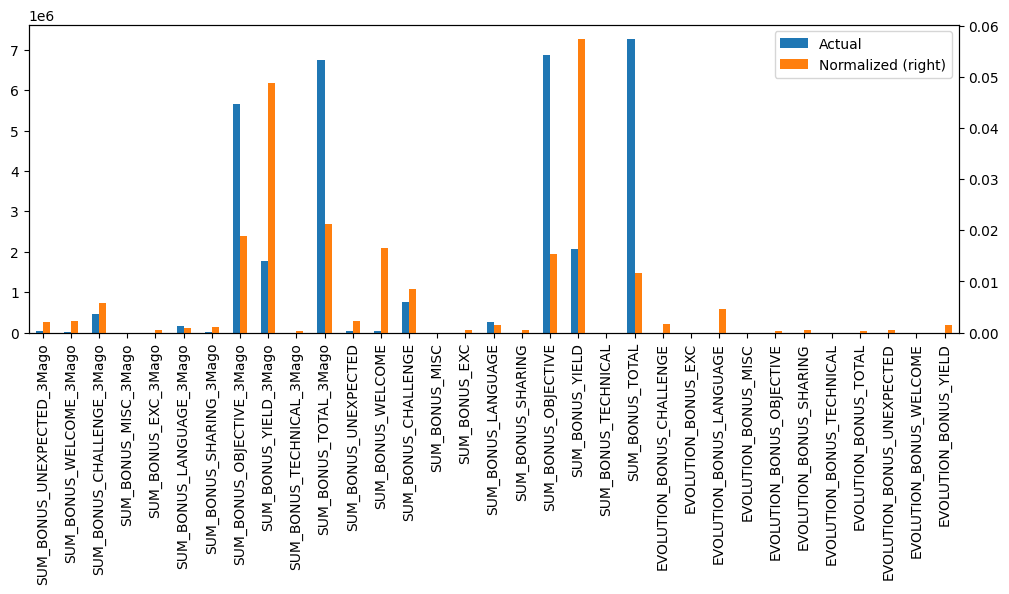

In [45]:
# Generate plot
fig, ax = plt.subplots(figsize=(12,4),dpi=100)
df_var.plot.bar(secondary_y='Normalized', 
                ax=ax,
                rot=90,
                title="")
plt.show();


<i>
<b>Interpretation of plot:</b><br>
Features with high variance stand out in both cases (actual values and normalized values) but it is clear that normalization does rescale the impact of the features.
</i> 

<i>
<b>Next:</b><br>
<ul>
    <li>Check impact variance threshold</li>
</ul></i>

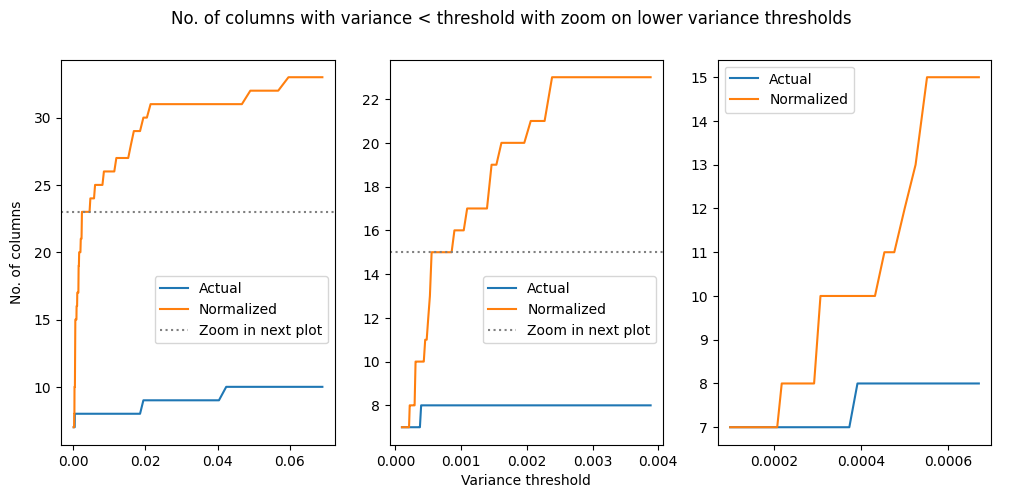

In [46]:
thres_lst, act_lst, norm_lst = list(), list(), list()
i = 0.0001

while i < 0.07:
    thres_lst.append(i)

    vt = VarianceThreshold(i)
    cols = len(df_train[bonus_cols].columns)
    try:
        feat_var = vt.fit(df_train[bonus_cols])
        col_mask = feat_var.get_support()
        act_lst.append(cols - col_mask.sum())
    except:
        acl_lst.append(cols)

    vt = VarianceThreshold(i)
    cols = len(df_scaled.columns)
    try:
        feat_var = vt.fit(df_scaled)
        col_mask = feat_var.get_support()
        norm_lst.append(cols - col_mask.sum())
    except:
        norm_lst.append(cols)

    i *= 1.05

var_thresholds = {'Threshold' : thres_lst,
                  'Actual' : act_lst,
                  'Normalized' : norm_lst
                 }
df_var_thresholds = pd.DataFrame.from_dict(var_thresholds)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (12, 5),
                                    dpi = 100)
df_var_thresholds.plot(x = 'Threshold', xlabel='',
                       y = ['Actual', 'Normalized'], 
                       ax = ax1)
ax1.axhline(y=23, 
            ls='dotted', 
            color='grey', 
            label='Zoom in next plot'
           )
ax1.legend(loc='center right', bbox_to_anchor=(1, 0.35))
df_var_thresholds[df_var_thresholds['Threshold'] < 0.004].plot(x = 'Threshold', xlabel = '',
                                                               y = ['Actual', 'Normalized'], 
                                                               ax = ax2)
ax2.axhline(y=15, 
            ls='dotted', 
            color='grey', 
            label='Zoom in next plot'
           )
ax2.legend(loc='center right', bbox_to_anchor=(1, 0.35))
df_var_thresholds[df_var_thresholds['Threshold'] < 0.0007].plot(x = 'Threshold', xlabel = '',
                                                                y = ['Actual', 'Normalized'], 
                                                                ax = ax3)

fig.suptitle("No. of columns with variance < threshold with zoom on lower variance thresholds")
# Add overall X and Y label
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Variance threshold")
plt.ylabel("No. of columns")
plt.show();


<i>
<b>Interpretation of plot:</b><br>
<ul>
    <li>7 features with 0 variance.  These have no added value at all.</li>
    <li>Threshold at 0, 0.0003 or 0.0006 seems to make most sense.</li>
</ul></i> 

<i>
<b>Next:</b><br>
<ul>
    <li>Let's check which columns are concerned</li>
</ul></i>

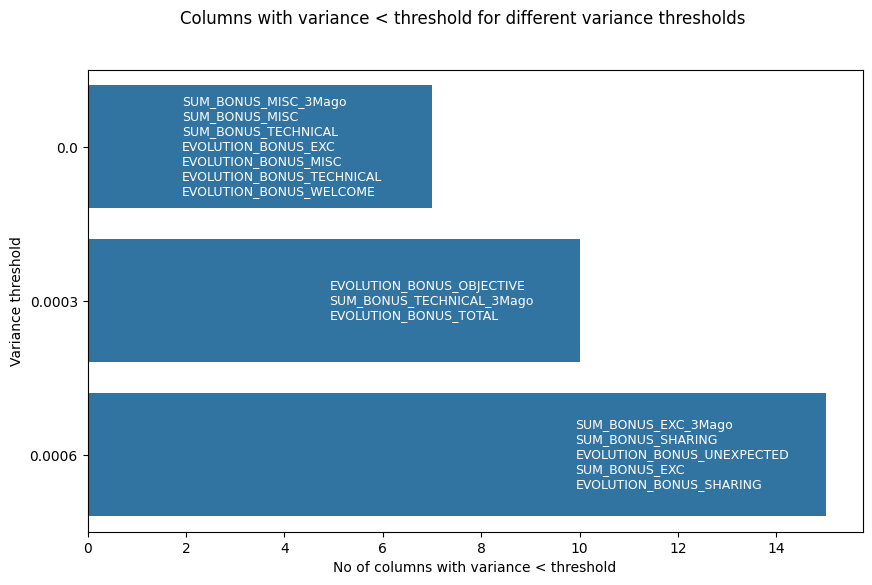

In [47]:
annot_lst, total_lst = list(), list()

# Calculate impacted columns for variance thresholds 0, 0.0003, 0.0006
for i in [0, 0.0003, 0.0006]:
    vt = VarianceThreshold(i)
    feat_var = vt.fit(df_scaled)
    col_mask = feat_var.get_support()
    feat_tmp = np.array(df_scaled.columns)
    total_lst.append(len(col_mask) - col_mask.sum())
    annot_lst.append(feat_tmp[np.invert(col_mask)].tolist())

# Construct labels for bar chart (= column names)
annot_lst[2] = list(set(annot_lst[2]) - set(annot_lst[1]))
annot_lst[1] = list(set(annot_lst[1]) - set(annot_lst[0]))

annot = list()
annot_conc = str()
for i in range(0, 3):
    new = True
    for j in annot_lst[i]:
        if new == True:
            annot_conc = j
            new = False
        else:
            annot_conc = annot_conc + "\n" + j
    annot.append(annot_conc)

# Generate plot
fig, ax = plt.subplots(figsize=(10, 6),dpi=100)
fig.suptitle("Columns with variance < threshold for different variance thresholds")
ax = sns.barplot(x = total_lst,
                 y = [0, 0.0003, 0.0006], 
                 orient = 'h'
                )
ax.bar_label(ax.containers[0], 
             labels=annot, 
             label_type='edge', 
             padding = -180,
             color = 'white',
             size=9)
plt.xlabel("No of columns with variance < threshold")
plt.ylabel("Variance threshold")
plt.show();

In [48]:
# 0.0006 doesn't sound like an overly risky threshold.  Let's take that and go on.
drop_var = annot_lst[0] + annot_lst[1] + annot_lst[2]
print(drop_var)

['SUM_BONUS_MISC_3Mago', 'SUM_BONUS_MISC', 'SUM_BONUS_TECHNICAL', 'EVOLUTION_BONUS_EXC', 'EVOLUTION_BONUS_MISC', 'EVOLUTION_BONUS_TECHNICAL', 'EVOLUTION_BONUS_WELCOME', 'EVOLUTION_BONUS_OBJECTIVE', 'SUM_BONUS_TECHNICAL_3Mago', 'EVOLUTION_BONUS_TOTAL', 'SUM_BONUS_EXC_3Mago', 'SUM_BONUS_SHARING', 'EVOLUTION_BONUS_UNEXPECTED', 'SUM_BONUS_EXC', 'EVOLUTION_BONUS_SHARING']


### Check feature correlation with target

<i>
<b>Numerical features:</b><br>
<ul>
<li>Check full correlation</li>
<li>Check correlation with only target</li>
</ul></i>

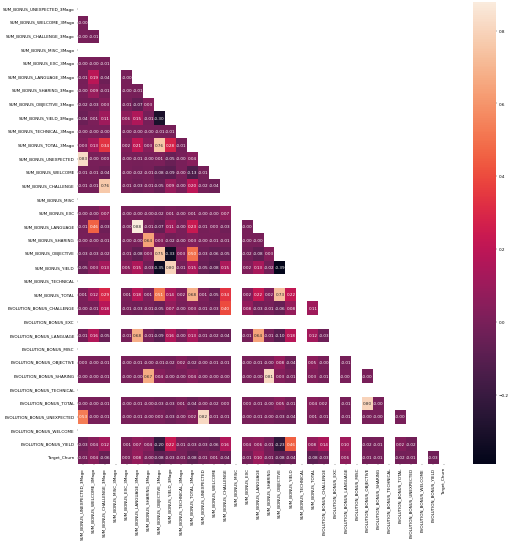

In [50]:
df_corr = pd.merge(left=df_train[bonus_cols], right=df_train['Target_Churn'], left_index=True, right_index=True)

fig, axes = plt.subplots(figsize=(20,20), dpi=30)
sns.heatmap(df_corr.corr(), annot=True, fmt='.2f', mask=np.triu(df_corr.corr()))

# Export plot
if switch_export_plots:
    plt.savefig('Output/CorrelationAll.jpg', bbox_inches='tight')

plt.show();

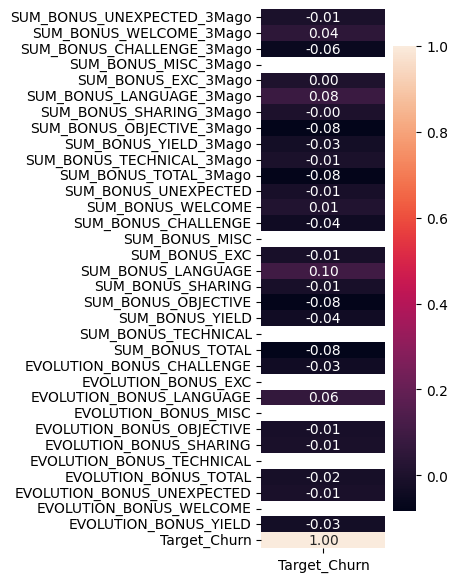

In [51]:
fig, axes = plt.subplots(figsize=(2,7), dpi=100)
sns.heatmap(pd.Series(df_corr.corr()['Target_Churn']).to_frame(), annot=True, fmt='.2f')

# Export plot
if switch_export_plots:
    plt.savefig('Output/CorrelationTarget.jpg', bbox_inches='tight')

plt.show();

<i>
<b>Observation:</b><br>
<ul>
<li>Only very few bonus features have a correlation < -0.05 or > 0.05 ...</li>
</ul></i>

<i>
<b>Categorical features:</b><br>
<ul>
<li>Check correlation with target via Chi Squared</li>
<li>We're sticking with the default p-value of 0.05 as a threshold for correlation.
</ul></i>

In [52]:
stats = chi2(df_train, feat_col=master_data_cols, target_col='Target_Churn')
drop_chi2 = stats.loc[stats['correlated'] == False]['col'].tolist()

print(drop_chi2)

['GENDER', 'EMPLOYEE_TYPE', 'DPT_CHANGE_FLAG', 'JOB', 'STATUS', 'EMPLOYEE_CLASS', 'HANDICAP', 'CITIZENSHIP', 'CONTRACT_TENURE']


### Check correlation between bonus details and total

In [53]:
df_bonus_sum = df_train.filter(regex='SUM_BONUS')
df_bonus_3m = df_bonus_sum.filter(regex='3Mago')
df_bonus_evo = df_train.filter(regex='EVOLUTION_BONUS')

for col in df_bonus_sum.columns:
    if '3Mago' in col:
        df_bonus_sum = df_bonus_sum.drop(col, axis='columns')

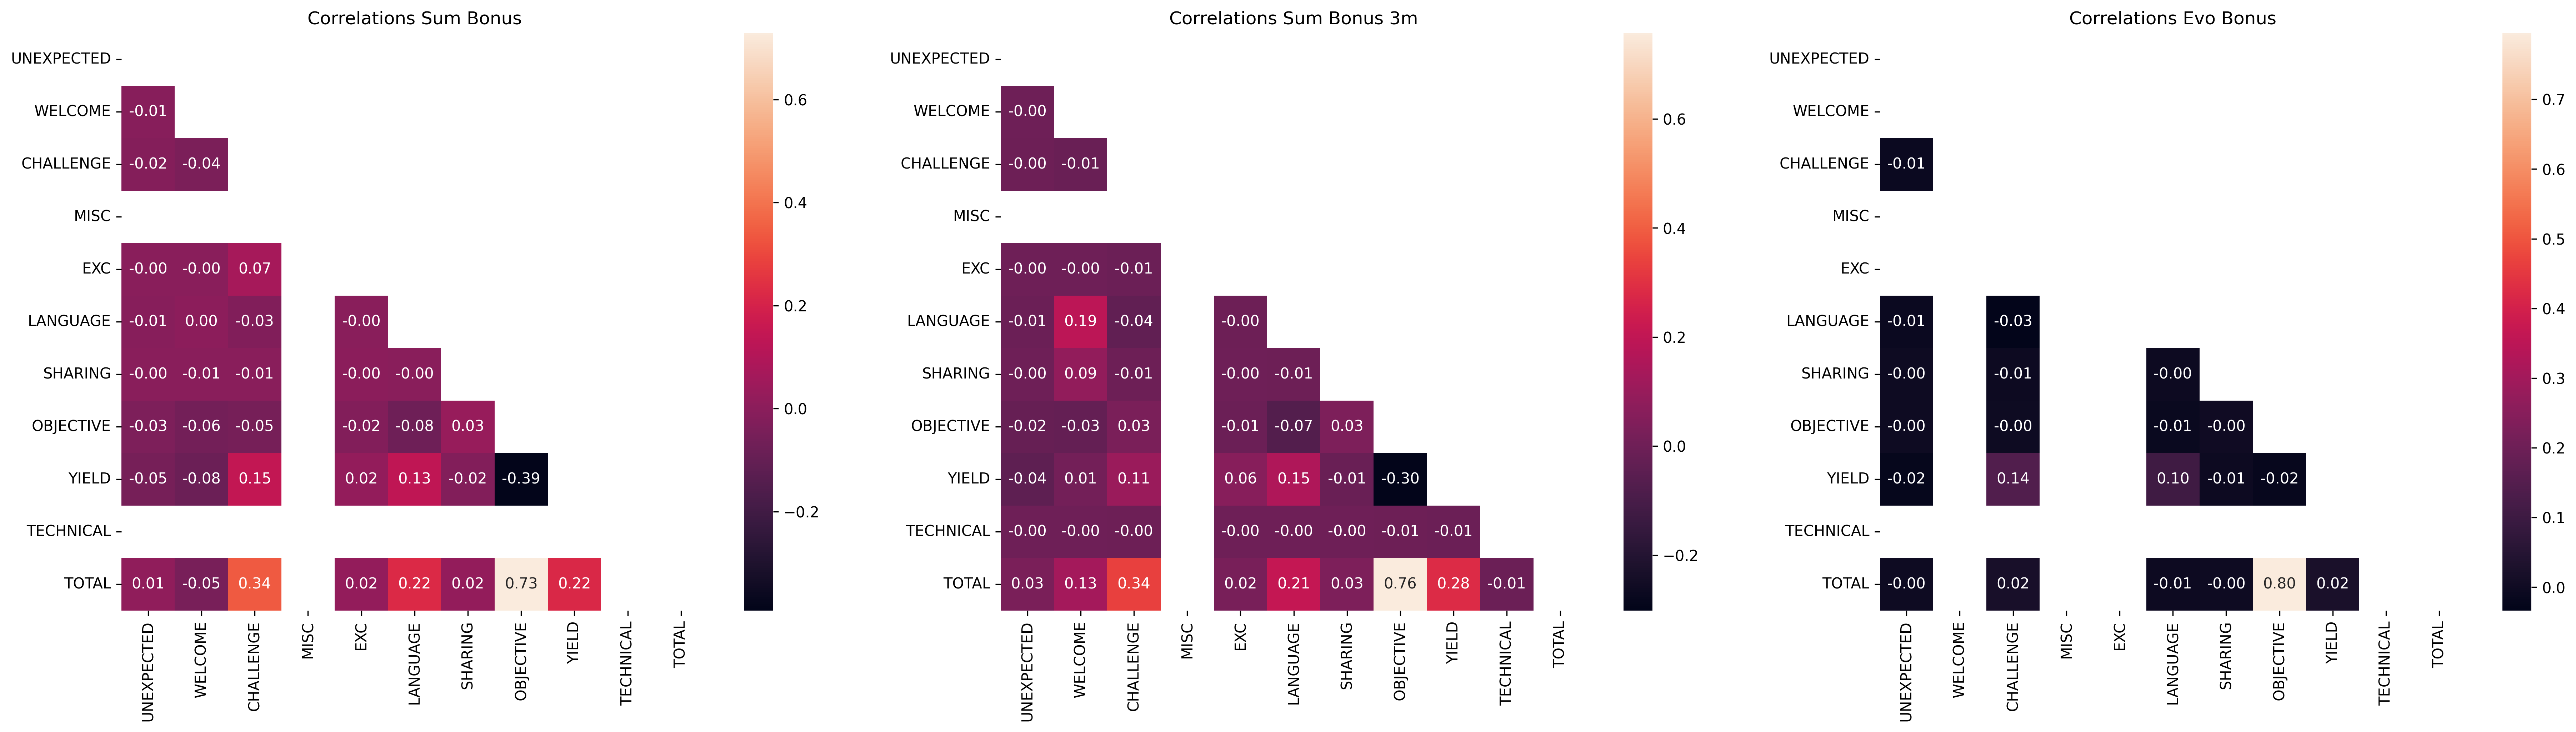

In [54]:
# Bonus correlation matrices
df_corrsum = df_bonus_sum.corr()
df_corr_3m = df_bonus_3m.corr()
df_correvo = df_bonus_evo.corr()

# Trim column headers
df_corrsum.rename(columns=lambda x: x.replace('SUM_BONUS_', ''), inplace=True)
df_corr_3m.rename(columns=lambda x: x.replace('SUM_BONUS_', ''), inplace=True)
df_corr_3m.rename(columns=lambda x: x.replace('_3Mago', ''), inplace=True)
df_correvo.rename(columns=lambda x: x.replace('EVOLUTION_BONUS_', ''), inplace=True)

# Trim index
df_corrsum.rename(index=lambda x: x.replace('SUM_BONUS_', ''), inplace=True)
df_corr_3m.rename(index=lambda x: x.replace('SUM_BONUS_', ''), inplace=True)
df_corr_3m.rename(index=lambda x: x.replace('_3Mago', ''), inplace=True)
df_correvo.rename(index=lambda x: x.replace('EVOLUTION_BONUS_', ''), inplace=True)

# Sort DF rows identically
df_corr_3m = df_corr_3m.reindex(labels=df_corrsum.columns.tolist())
df_correvo = df_correvo.reindex(labels=df_corrsum.columns.tolist())

# Sort DF columns identically
df_corr_3m = df_corr_3m[df_corrsum.columns.tolist()]
df_correvo = df_correvo[df_corrsum.columns.tolist()]

# Print correlation heatmaps in single row
fig, axes = plt.subplots(figsize=(30, 7), dpi=300, nrows=1, ncols=3)
sns.heatmap(df_corrsum, ax=axes[0], annot=True, fmt='.2f', mask=np.triu(df_corrsum)) 
sns.heatmap(df_corr_3m, ax=axes[1], annot=True, fmt='.2f', mask=np.triu(df_corr_3m))
sns.heatmap(df_correvo, ax=axes[2], annot=True, fmt='.2f', mask=np.triu(df_correvo))
axes[0].set_title('Correlations Sum Bonus')
axes[1].set_title('Correlations Sum Bonus 3m')
axes[2].set_title('Correlations Evo Bonus')
plt.subplots_adjust(wspace=0.2)

# Export plot
if switch_export_plots:
    plt.savefig('Output/CorrelationBonuses.jpg', bbox_inches='tight')
    
plt.show();

### Check mutual information

<i>
Mutual information is an estimation of the relevance of the features, so we calculate an average mutual info over 10 runs.
</i> 

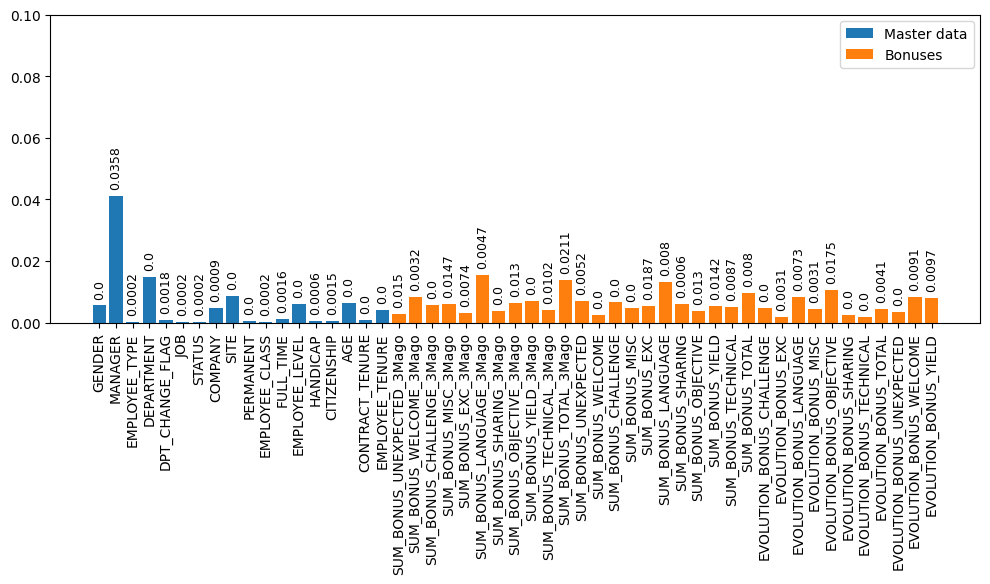

In [55]:
cols_to_encode = [x for x in master_data_cols if x != 'AGE' and x != 'CONTRACT_TENURE' and x != 'EMPLOYEE_TENURE']
df_encoded = df_train.copy()

# Convert categorical variables to numbers
encoder = OrdinalEncoder(encoding_method='arbitrary',
                         variables=cols_to_encode
                        )
df_encoded = encoder.fit_transform(df_encoded)

df_encoded.drop('Target_Churn', axis=1, inplace=True)

# Build mask for discrete features (and coloring in plot)
discrete_lst, colors_lst, labels_lst = list(), list(), list()
for col in df_encoded.columns:
    if col in master_data_cols:
        discrete_lst.append(True)
        colors_lst.append('tab:blue')
        labels_lst.append('_Master data')
    else:
        discrete_lst.append(False)
        colors_lst.append('tab:orange')
        labels_lst.append('_Bonuses')

# Replace first occurrence of each label with the actual label.  Labels starting with _ are ignored.
index = labels_lst.index('_Master data')
labels_lst[index] = 'Master data'
index = labels_lst.index('_Bonuses')
labels_lst[index] = 'Bonuses'

i = 1
while i <= 10:
    # Calculate mutual info and convert to dataframe
    mut_info = mutual_info_regression(df_encoded, df_train['Target_Churn'], discrete_features=discrete_lst)
    col_name = str('Run_' + str(i))
    if i == 1:
        df_mut_info = pd.DataFrame(data=mut_info, index=df_encoded.columns, columns=[col_name])
    else:
        df_mut_info[col_name] = mut_info.tolist()
    i += 1

# Calculate average mutual info
mut_info_avg = df_mut_info.mean(axis=1)
df_mut_info_avg = pd.DataFrame(data=mut_info_avg, index=df_encoded.columns, columns=['Avg. mutual info'])

# Generate plot
fig, ax = plt.subplots(figsize=(12,4),dpi=100)
ax.bar(df_mut_info_avg.index, 
       df_mut_info_avg['Avg. mutual info'],
       label=labels_lst,
       color=colors_lst
      )
annot = np.around(mut_info, 4)
ax.bar_label(ax.containers[0], 
             labels=annot, 
             label_type='edge',
             padding=5,
             rotation=90,
             size=9)
ax.tick_params(axis='x', rotation=90)
plt.legend()
plt.ylim(0, 0.1)

# Export plot
if switch_export_plots:
    plt.savefig('Output/MutualInformation_MasterVsBonuses.jpg', bbox_inches='tight')

plt.show();

<i>
<b>Interpretation of plot:</b><br>
<ul>
<li>Because Mutual Information is an estimation of the relevance of the features, the plot varies with every run.<br>Even the features with mutual information = 0 vary between runs.</li>
<li>Although some features stand out, there is in general little difference between master data features and bonus features.  In both feature groups there are features with high and low mutual information.</li>
</ul>
</i> 

In [56]:
# Build list of features that will be dropped because of selection methods above
feat_drop = drop_const + drop_var + drop_chi2
feat_drop = list(set(feat_drop))

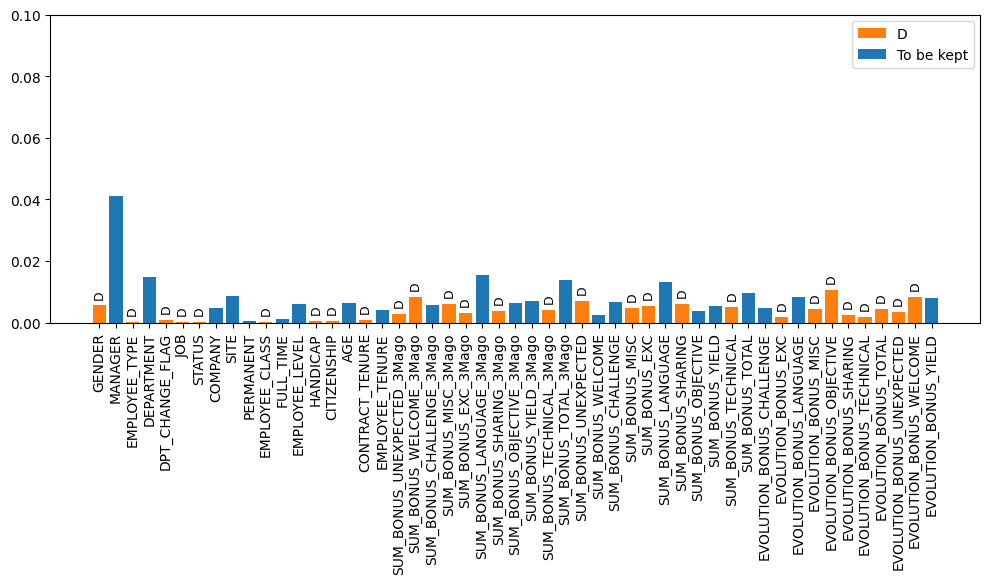

In [57]:
# Build mask for coloring
colors_lst, labels_lst = list(), list()
for col in df_encoded.columns:
    if col in feat_drop:
        colors_lst.append('tab:orange')
        labels_lst.append('_To be dropped')
    else:
        colors_lst.append('tab:blue')
        labels_lst.append('_To be kept')

# Replace first occurrence of each label with the actual label.  Labels starting with _ are ignored.
index = labels_lst.index('_To be dropped')
labels_lst[index] = 'D'
index = labels_lst.index('_To be kept')
labels_lst[index] = 'To be kept'

# Generate plot
fig, ax = plt.subplots(figsize=(12,4),dpi=100)
ax.bar(df_mut_info_avg.index, 
       df_mut_info_avg['Avg. mutual info'],
       label=labels_lst,
       color=colors_lst
      )

annot = list(map(lambda x: x if x != '_To be dropped' else 'D', labels_lst))
annot = list(map(lambda x: x if x != '_To be kept' else '', annot))
annot[index] = ''

ax.bar_label(ax.containers[0], 
             labels=annot, 
             label_type='edge',
             padding=5,
             rotation=90,
             size=9)
ax.tick_params(axis='x', rotation=90)
plt.legend()
plt.ylim(0, 0.1)

# Export plot
if switch_export_plots:
    plt.savefig('Output/MutualInformation_DroppedVsKept.jpg', bbox_inches='tight')

plt.show();

<i>
<b>Interpretation of plot:</b><br>
<ul>
<li>The results for the master data columns seem to be in line with Chi 2.</li>
<li>But for the bonus columns, the result is less consistent with the correlation test.</li>
<li>The method seems inconclusive in the case at hand.</li>
</ul>
</i> 

# Data transformation

In [58]:
# Split features and target
X = df_train.drop(['Target_Churn'], axis='columns')
y = df_train['Target_Churn']

# Convert master data features into categorical type
cat_feat = master_data_cols.copy()
for col in cat_feat:
    if not df_train[col].dtype.kind in 'iuf':
        df_train[col] = df_train[col].astype('category')
    else:
        cat_feat.remove(col)

# Z = dataframe with irrelevant features
Z = X.drop(feat_drop, axis='columns')

In [59]:
# Build list of features (columns) without the irrelevant ones
master_data_cols_Z = master_data_cols.copy()
bonus_cols_Z = bonus_cols.copy()

for col in feat_drop:
    if col in master_data_cols:
        master_data_cols_Z.remove(col)
    elif col in bonus_cols:
        bonus_cols_Z.remove(col)


In [60]:
X_scaled, df_X_scaled, _ = col_trans(X, master_data_cols, bonus_cols)
Z_scaled, df_Z_scaled, _ = col_trans(Z, master_data_cols_Z, bonus_cols_Z)

### Principal Components

In [61]:
if switch_pca_feat_sel:
    pca = PCA()   # PCA on all features
    principal_components = pca.fit_transform(X_scaled)

In [62]:
if switch_pca_feat_sel:
    explained_variance = []

    for n in range(1,11):
        pca = PCA(n_components=n)
        pca.fit(X_scaled)

        explained_variance.append(np.sum(pca.explained_variance_ratio_))

    plt.plot(range(1,11), explained_variance)
    plt.xlabel("Number of Components")
    plt.ylabel("Variance Explained");

In [63]:
#pca.n_components_
#pca.components_.shape

In [64]:
# Relatie tussen PCA en features:
if switch_pca_feat_sel:
    pca_comp = pd.DataFrame(pca.components_, index=['PC1','PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
#    pca_comp.columns = col_trans.get_feature_names_out()   # Replace generated column headers with actual feature names
    pca_comp.columns = df_X_scaled.columns   # Replace generated column headers with actual feature names
    pca_comp.head()

    #plt.figure(figsize=(20,3),dpi=100)
    #sns.heatmap(pca_comp,annot=True)

In [65]:
# Explained variance mee in rekening brengen bij correlatie van de features
if switch_pca_feat_sel:
    display(pca.explained_variance_ratio_)

    pca_w = pca_comp.mul((pca.explained_variance_ratio_), axis='index').copy()

    ## Normaliseren
    #pca_w = pca_w / pca_w.sum().abs().sum()   # Totaal van alle PCA correlaties op 1 brengen


In [66]:
if switch_pca_feat_sel:
    pca_wabs = pca_w.abs().copy()

    # Calculate total correlation per feature rather than by OneHotEncoder split
    lst_cum = ['MANAGER', 'DEPARTMENT', 'DPT_CHANGE_FLAG', 'COMPANY', 'SITE', 'FULL_TIME', 'EMPLOYEE_LEVEL', 'HANDICAP', 'CITIZENSHIP']
    for col in lst_cum:
        prefix = 'cat__' + col

        # Add column with total correlation
        pca_wabs[col] = pca_wabs.filter(regex=prefix, axis='columns').sum(axis='columns')

        # Remove columns with correlations for individual OneHotEncoder splits
        fltr = filter(lambda x: x.startswith(prefix), pca_wabs.columns)
        pca_wabs.drop(list(fltr), axis='columns', inplace=True)

    # Remove prefixes from column names
    dict_colnames = {}
    for i, col in enumerate(pca_wabs.columns):
        if col.find('__') > 0:
            dict_colnames[col] = col[ (col.find('__')+2) : ]

    pca_wabs.rename(columns=dict_colnames, inplace=True)

    display(pca_wabs.head())


In [67]:
# DF opbouwen met gecumuleerde feature importances over de 10 PC's
if switch_pca_feat_sel:
    pca_feat_imp = pd.DataFrame(data={'Importance' : pca_w.sum()}, index=df_X_scaled.columns)

    # Features aggregeren (undo OneHotEncoding)
    pca_feat_imp = agg_feat_imp(pca_feat_imp)

    # Features plotten volgens afnemend belang
    plot_feat_imp(pca_feat_imp, export=switch_export_plots, file_name='Output/FeatureImportance_PrincipalComponents.jpg')

In [68]:
# Features sorteren volgens afnemend gecumuleerd belang over de 10 PC
if switch_pca_feat_sel:
    pca_feat_imp = pd.DataFrame(data={'Importance' : pca_wabs.sum()}, index=pca_wabs.columns)
    pca_feat_imp.sort_values('Importance', ascending=False, inplace=True)

    plt.figure(figsize=(12,6),dpi=100)
    sns.barplot(pca_feat_imp, x=pca_feat_imp.index, y=pca_feat_imp['Importance'])
    plt.xticks(rotation=90);

### Random Forest

In [69]:
if switch_rfc_feat_sel:
    n_estimators=[100, 128, 150, 200, 250, 300, 350]
    max_features= [2, 4, 6, 8, 10]
    bootstrap = [True]
    oob_score = [True]   # oob_score heeft geen impact op performantie, geeft enkel idee van accuraatheid van model
    # Best params na 1e run: {'bootstrap': True, 'max_features': 8, 'n_estimators': 128, 'oob_score': True}

    param_grid = {'n_estimators':n_estimators,
                  'max_features':max_features,
                  'bootstrap':bootstrap,
                  'oob_score':oob_score,
                  'class_weight':class_weight,
                 }

    rfc = RandomForestClassifier()
    grid = GridSearchCV(rfc,param_grid)
    grid.fit(X_scaled, y)

    display(grid.best_params_)   # parameters beste estimator

Output: {'bootstrap': True, 'max_features': 8, 'n_estimators': 300, 'oob_score': True}

In [70]:
if switch_rfc_feat_sel:
    grid.fit(Z_scaled, y)
    display(grid.best_params_)

Output: {'bootstrap': True, 'max_features': 2, 'n_estimators': 250, 'oob_score': True}

In [71]:
# Best model based on training with all features:
rfc_X = RandomForestClassifier(bootstrap=True, max_features=8, n_estimators=300, oob_score=True)
rfc_X.fit(X_scaled, y)
rfc_X.oob_score_   # oob_score is tegenovergestelde van OOB error !

0.8664682117797151

In [72]:
# Best model based on training with reduced feature set:
rfc_Z = RandomForestClassifier(bootstrap=True, max_features=2, n_estimators=250, oob_score=True)
rfc_Z.fit(Z_scaled, y)
rfc_Z.oob_score_   # oob_score is tegenovergestelde van OOB error !

0.8641292791834999

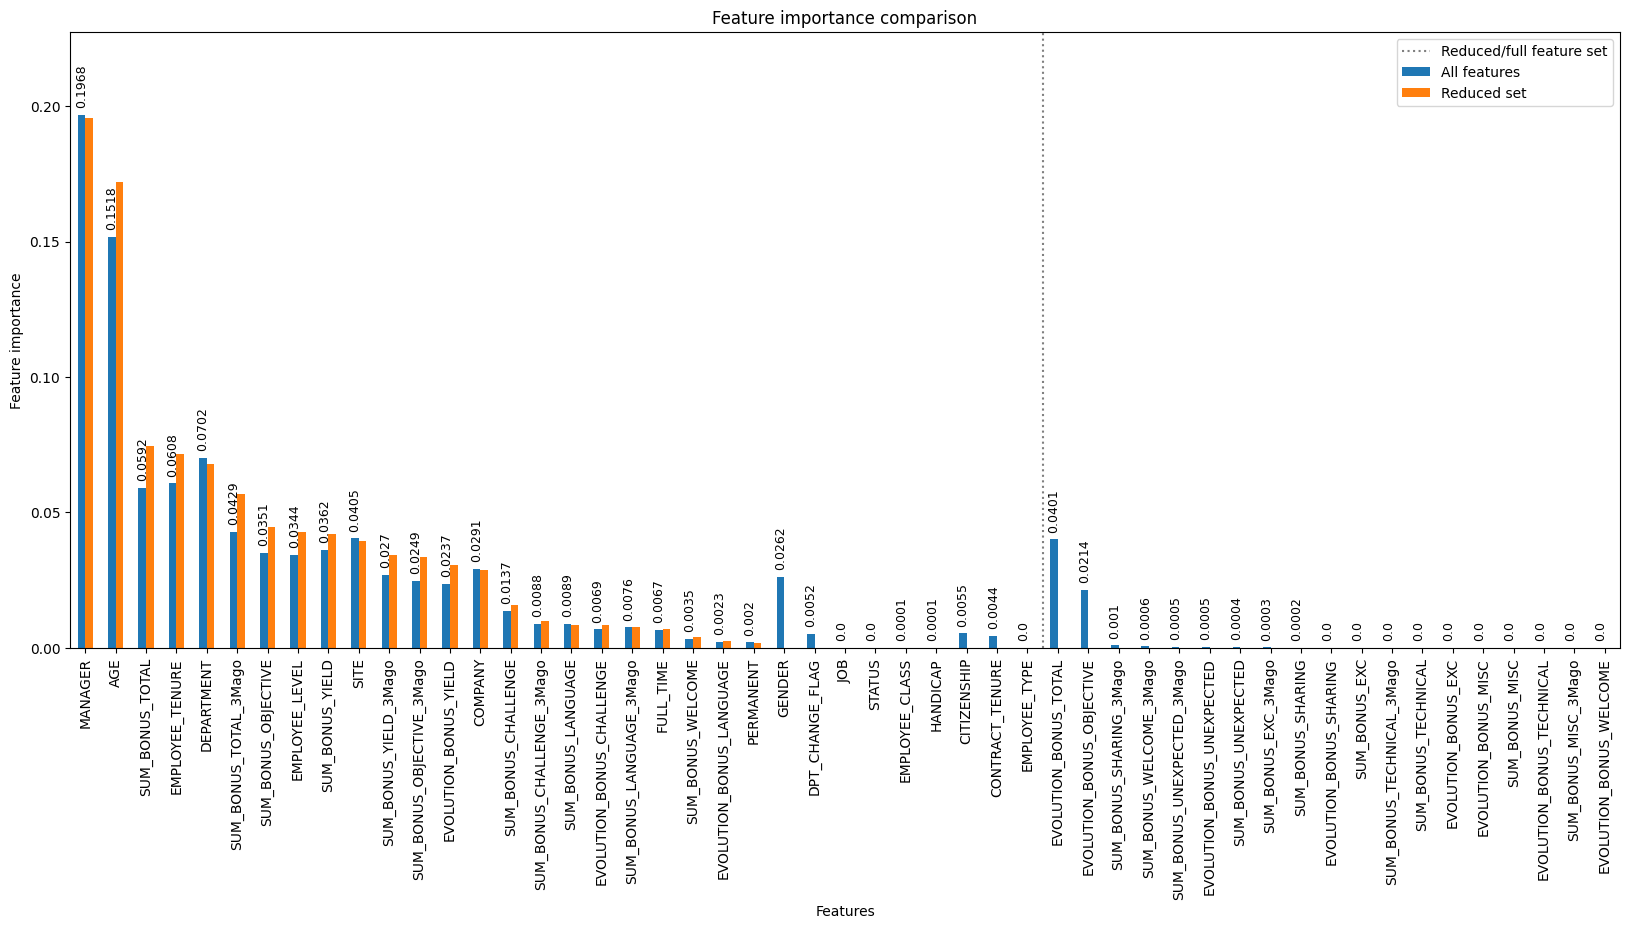

In [73]:
# Build DF with feature importances
rfc_feat_imp_X = pd.DataFrame(data={'Importance' : rfc_X.feature_importances_}, index=df_X_scaled.columns)
rfc_feat_imp_Z = pd.DataFrame(data={'Importance' : rfc_Z.feature_importances_}, index=df_Z_scaled.columns)

# Aggregate features (undo OneHotEncoding)
rfc_feat_imp_X = agg_feat_imp(rfc_feat_imp_X)
rfc_feat_imp_Z = agg_feat_imp(rfc_feat_imp_Z)

plot_feat_comp(rfc_feat_imp_X, rfc_feat_imp_Z, sort_col='Importance', export=switch_export_plots, 
               file_name='Output/FeatureImportance_RandomForest.jpg', show=True)

<i>
<b>Interpretation of plot:</b><br>
<ul>
<li>The result for the reduced feature set are in line with those for the full set, except for Gender which is assigned higher importance when the model is trained on the full feature set.</li>
<li>On the other hand it seems better not to drop Evolution Bonus Total and Evolution Bonus Objective.</li>
</ul>
</i> 

### Gradient boosting

In [ ]:
if switch_gb_feat_sel:
    n_est = [80, 100, 150, 200, 300]
    max_f = [6, 8, 10]
    max_d = [4, 5, 6]
    l_rate = [0.02, 0.05, 0.1]
    # Best params after 1st run: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 8, 'n_estimators': 100}
    # Best params after 2nd run: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 6, 'n_estimators': 200}

    param_grid = {'n_estimators': n_est,
                'max_features': max_f,
                'max_depth': max_d,
                'learning_rate': l_rate}

    gbc = GradientBoostingClassifier()
    grid = GridSearchCV(gbc, param_grid)
    grid.fit(X_scaled, y)

    display(grid.best_params_)   # parameters beste estimator

Output: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 8, 'n_estimators': 200}

In [ ]:
if switch_gb_feat_sel:
    n_est = [105, 110, 115, 120, 125]
    max_f = [9, 10, 11, 12, 13]
    max_d = [4, 5, 6, 7, 8]
    l_rate = [0.03, 0.05, 0.75, 0.1, 0.12]
    # Best params after 1st run:  {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 10, 'n_estimators': 100}
    # Best params after 2nd run:  {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 14, 'n_estimators': 150}
    # Best params after 3rd run:  {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 14, 'n_estimators': 80}
    # Best params after 4th run:  {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 12, 'n_estimators': 90}
    # Best params after 5th run:  {'learning_rate': 0.1,  'max_depth': 5, 'max_features': 11, 'n_estimators': 90}
    # Best params after 6th run:  {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 12, 'n_estimators': 100}
    # Best params after 7th run:  {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 12, 'n_estimators': 90}
    # Best params after 8th run:  {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 10, 'n_estimators': 80}
    # Best params after 9th run:  {'learning_rate': 0.1,  'max_depth': 5, 'max_features': 11, 'n_estimators': 90}
    # Best params after 9th run:  {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 13, 'n_estimators': 105}
    # Best params after 10th run: {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 10, 'n_estimators': 95}
    # Best params after 10th run: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 10, 'n_estimators': 110}
    # Best params after 11th run: {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 11, 'n_estimators': 115}

    param_grid = {'n_estimators': n_est,
                'max_features': max_f,
                'max_depth': max_d,
                'learning_rate': l_rate}

    gbc = GradientBoostingClassifier()
    grid = GridSearchCV(gbc, param_grid)
    grid.fit(Z_scaled, y)
    display(grid.best_params_)   # parameters beste estimator

Output: {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 11, 'n_estimators': 115}

In [ ]:
gbc_X = GradientBoostingClassifier(learning_rate= 0.05, max_depth= 5, max_features= 8, n_estimators= 200)
gbc_X.fit(X_scaled, y)

In [ ]:
gbc_Z = GradientBoostingClassifier(learning_rate= 0.05, max_depth= 6, max_features= 11, n_estimators= 115)
gbc_Z.fit(Z_scaled, y)

In [ ]:
# Build DF with feature importances
gb_feat_imp_X = pd.DataFrame(data={'Importance' : gbc_X.feature_importances_}, index=df_X_scaled.columns)
gb_feat_imp_Z = pd.DataFrame(data={'Importance' : gbc_Z.feature_importances_}, index=df_Z_scaled.columns)

# Aggregate features (undo OneHotEncoding)
gb_feat_imp_X = agg_feat_imp(gb_feat_imp_X)
gb_feat_imp_Z = agg_feat_imp(gb_feat_imp_Z)

plot_feat_comp(gb_feat_imp_X, gb_feat_imp_Z, sort_col='Importance', export=switch_export_plots, 
               file_name='Output/FeatureImportance_GradientBoosting.jpg', show=True)

<i>
<b>Interpretation of plot:</b><br>
<ul>
<li>The result for the reduced feature set are in line with those for the full set, except for Sum Bonus Language which is assigned higher importance when the model is trained on the full feature set.</li>
<li>On the other hand it seems better not to drop Evolution Bonus Total and Evolution Bonus Objective.  (Note that the Random Forest came to a similar conclusion.)</li>
</ul>
</i> 

## Logistic Regression

In [ ]:
lr_X = LogisticRegression()
lr_X.fit(X_scaled, y)

In [ ]:
lr_Z = LogisticRegression()
lr_Z.fit(Z_scaled, y)

In [ ]:
# Build DF with feature importances
lr_feat_imp_X = pd.DataFrame(data={'Importance' : lr_X.coef_[0]}, index=df_X_scaled.columns)
lr_feat_imp_Z = pd.DataFrame(data={'Importance' : lr_Z.coef_[0]}, index=df_Z_scaled.columns)

# Aggregate features (undo OneHotEncoding)
lr_feat_imp_X = agg_feat_imp(lr_feat_imp_X)
lr_feat_imp_Z = agg_feat_imp(lr_feat_imp_Z)

plot_feat_comp(lr_feat_imp_X, lr_feat_imp_Z, sort_col='Importance', export=switch_export_plots, 
               file_name='Output/FeatureImportance_GradientBoosting.jpg', show=True)

# Predictions

## Data preparations

### Check if dataset is balanced

In [ ]:
sns.countplot(data=df_train, x='Target_Churn');

<i>
<b>Interpretation of plot:</b><br>
<ul>
<li>Dataset is imbalanced.</li>
</ul>
</i> 

### Train-test split

In [ ]:
# Based on feature importance check 'Random Forest' and 'Gradient Boost', we keep these features as well.
feat_drop.remove('EVOLUTION_BONUS_TOTAL')
feat_drop.remove('EVOLUTION_BONUS_OBJECTIVE')

In [ ]:
# Split features and target
X = df_train.drop(['Target_Churn'], axis='columns')
y = df_train['Target_Churn']

# Convert master data features into categorical type
cat_feat = master_data_cols.copy()
for col in cat_feat:
    if not df_train[col].dtype.kind in 'iuf':
        df_train[col] = df_train[col].astype('category')
    else:
        cat_feat.remove(col)

# Only keep relevant features
X = X.drop(feat_drop, axis='columns')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Scaling & transformation

In [ ]:
# Build list of features (columns) without the irrelevant ones
master_data_cols_X = master_data_cols.copy()
bonus_cols_X = bonus_cols.copy()

for col in feat_drop:
    if col in master_data_cols:
        master_data_cols_X.remove(col)
    elif col in bonus_cols:
        bonus_cols_X.remove(col)

In [ ]:
# Remove values from X_test that don't occur in X_train because they disrupt the transformation
start_point = len(X_test)
for col in master_data_cols_X:
    for value in X_test[col].values:
        if not value in X_train[col].values:
            idx = X_test.loc[X_test[col] == value].index
            X_test.drop(idx, inplace=True)
            y_test.drop(idx, inplace=True)
end_point = len(X_test)
drop_rate = round(((start_point - end_point) / start_point) *100, 2)
            
print(f"{start_point - end_point} lines removed ({drop_rate}%)")

In [ ]:
# Fit & transform
X_train_scaled, df_X_train_scaled, transformer = col_trans(X_train, master_data_cols_X, bonus_cols_X)

# Transform based on X_train fit
X_test_scaled = transformer.transform(X_test)
df_X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=transformer.get_feature_names_out())

<h2>Choice of models</h2>
<i>
<ul>
    <li>Random forest</li>
    <li>Support Vector Machines</li>
    <li>Logistic regression</li>
    <li>Neural Network</li>
</ul>
</i>

### Random forest

In [ ]:
if switch_rfc_pred:
    n_estimators=[100, 128, 150, 200, 256, 300, 350]
    max_features= [2, 4, 6, 8, 10]
    bootstrap = [True]
    oob_score = [True]   # oob_score heeft geen impact op performantie, geeft enkel idee van accuraatheid van model
    class_weight = ['balanced']
    # Best params na 1e run:  {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 4, 'n_estimators': 300, 'oob_score': True}

    param_grid = {'n_estimators':n_estimators,
                  'max_features':max_features,
                  'bootstrap':bootstrap,
                  'oob_score':oob_score,
                  'class_weight':class_weight,
                 }

    rfc = RandomForestClassifier()
    grid = GridSearchCV(rfc, param_grid)
    grid.fit(X_train_scaled, y_train)

    display(grid.best_params_)   # parameters beste estimator

Output: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 4, 'n_estimators': 300, 'oob_score': True}

In [ ]:
# Best model based on training with all features:
rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced', max_features=4, n_estimators=300, oob_score=True)

print_results(model=rfc, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test)


### Support Vector Machines

In [ ]:
if switch_svm_pred:
    regularization = [0.001, 0.005, 0.01, 0.05]
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    gamma = ['scale', 'auto']
    class_weight = ['balanced']
    # Best params after 1st run: {'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}
    # Best params after 2nd run: {'C': 0.005, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}
    
    param_grid = {'C': regularization,
                  'kernel': kernel,
                  'gamma': gamma,
                  'class_weight':class_weight,
                 }

    svc = SVC()
    grid = GridSearchCV(svc, param_grid)
    grid.fit(X_train_scaled, y_train)

    display(grid.best_params_)   # parameters beste estimator    

Output: {'C': 0.005, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}

In [ ]:
# Best model based on training with all features:
svc = SVC(C = 0.005, class_weight = 'balanced', gamma = 'scale', kernel = 'poly', probability=True)

print_results(model=svc, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test)


### Logistic Regression

In [ ]:
if switch_lr_pred:
    regularization = [1e-08, 5e-08, 1e-07, 5e-07, 1e-06, 5e-06, 1e-05, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
    solver = ['lbfgs', 'liblinear', 'sag', 'saga']
    penalty = ['l1', '‘l2', 'elasticnet', None]
    l1_ratio = [0.2, 0.4, 0.6, 0.8]
    class_weight = ['balanced']
    max_iter = [32, 64, 128, 256]
    # Best params after 1st run: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
    # Best params after 2nd run: {'C': 1e-05, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
    # Best params after 3rd run: {'C': 1e-08, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
    
    param_grid = {'penalty': penalty,
                  'C': regularization,
                  'solver': solver,
                  'class_weight':class_weight,
                 }

    lr = LogisticRegression()
    grid = GridSearchCV(lr, param_grid)
    grid.fit(X_train_scaled, y_train)

    display(grid.best_params_)   # parameters beste estimator        

Output: {'C': 1e-08, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} <br>
However, lower C (higher regularization) makes precising and recall for target = 1 both drop to 0.

In [ ]:
# Best model based on training with all features:
lr = LogisticRegression(C = 0.01, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear')

print_results(model=lr, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test)


### Neural Network

In [ ]:
X_train_arr = np.asarray(X_train_scaled)
X_test_arr = np.asarray(X_test_scaled)

In [ ]:
X_train_arr.shape

In [ ]:
nn = Sequential()

# nn.add(Dropout(0.2))
nn.add(Dense(256, 
             activation='relu', 
             input_shape=(525,)
            )
      )
# nn.add(BatchNormalization())
# nn.add(Dropout(0.2))
# nn.add(Dense(16, 
#              activation='leaky_relu'
#             )
#          )
# nn.add(BatchNormalization())
# nn.add(Dropout(0.2))
nn.add(Dense(64, 
             activation='relu'
            )
         )
# nn.add(BatchNormalization())
# nn.add(Dropout(0.2))
# nn.add(Dense(8, 
#              activation='leaky_relu'
#             )
#          )
# nn.add(BatchNormalization())
# nn.add(Dropout(0.2))
nn.add(Dense(16, 
             activation='relu'
            )
         )

nn.add(Dense(1, 
             activation="sigmoid")
      )

nn.compile(optimizer=Adam(learning_rate=0.3, weight_decay=0.9, use_ema=True),
           loss=BinaryCrossentropy(from_logits=True),
           metrics=["accuracy"]
          )

In [ ]:
# Calculate imbalance so this can be countered by the model
counts = np.bincount(np.asarray(y_train.astype('int64')))
weight_for_0 = counts[0] / (counts[0] + counts[1])
weight_for_1 = counts[1] / (counts[0] + counts[1])

In [ ]:
# Train the model
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   patience=10, 
                   verbose=1)
"""
Parameters:
- mode = 'min' or 'max', default = 'auto'.
- verbose = '1': print epoch no.
- patience = integer: no. of epoch in which no improvement
- min_delta = int: minimal improvement required, avoid fractional improvements
- baseline = float: only stop training if performance stays above or below the given threshold
Documentation: https://keras.io/api/callbacks/early_stopping/
"""

checkpoint_path = '/checkpoints/checkpoint.weights.h5'
mc = ModelCheckpoint(filepath=checkpoint_path, 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)
"""
Parameters
- save_best_only=True: If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.
- save_weights_only=True: only saved weights rather than entire model
- save_freq = 'epoch' or integer: if integer, then model is saved after specified no. of batches, default = 'epoch'
Documentation: https://keras.io/api/callbacks/model_checkpoint/
"""

class_weight = {0: weight_for_0, 1: weight_for_1}

history = nn.fit(X_train_scaled,
                 y_train,
                 epochs=100,
                 batch_size=32,
                 validation_split=0.25,
                 callbacks=[es, mc],
                 class_weight=class_weight,
                 verbose=0)


In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

print_nn_comp(loss=loss, val_loss=val_loss, acc=acc, val_acc=val_acc, epochs=epochs)


In [ ]:
# Fetch best model from checkpoints
saved_model = load_model(checkpoint_path)
y_pred = saved_model.predict(X_test_scaled)
y_squeezed = tf.squeeze(y_pred)
y_squeezed = np.array([1 if x >= 0.5 else 0 for x in y_squeezed])
unique, counts = np.unique(y_squeezed, return_counts=True)
dict(zip(unique, counts))

# Print classification report
print('\n', classification_report(y_test, y_squeezed))

## Retry with balanced dataset

<i>
    
</i>

In [ ]:
# Rebuild dataframe incl. target.  We need the target in order to select an equal number of rows with 0 and 1.
# We restart from X_train rather than df_train so we don't have to redo the data preparation,
# and the train-test split remains the same.
df_tmp = X_train.copy()
df_tmp['Target_Churn'] = y_train

# Create balanced dataframe with same number of rows with 0 and 1.  Rows with 0 are randomly selected.
df_balanced = df_tmp[df_tmp['Target_Churn'] == 0].sample(df_tmp['Target_Churn'].sum())
df_balanced = pd.concat([df_balanced, df_tmp[df_tmp['Target_Churn'] == 1]])

# Split features and target
X_train_bal = df_balanced.drop(['Target_Churn'], axis='columns')
y_train_bal = df_balanced['Target_Churn']


In [ ]:
# Transform based on X_train fit
X_train_bal_scaled = transformer.transform(X_train_bal)
df_X_train_bal_scaled = pd.DataFrame(data=X_train_bal_scaled, columns=transformer.get_feature_names_out())

### Random forest

In [ ]:
if switch_rfc_pred:
    n_estimators=[100, 128, 150, 200, 256, 300, 350]
    max_features= [2, 4, 6, 8, 10]
    bootstrap = [True]
    oob_score = [True]   # oob_score heeft geen impact op performantie, geeft enkel idee van accuraatheid van model
#    class_weight = ['balanced']
    # Best params na 1e run:  {'bootstrap': True, 'max_features': 4, 'n_estimators': 200, 'oob_score': True}

    param_grid = {'n_estimators':n_estimators,
                  'max_features':max_features,
                  'bootstrap':bootstrap,
                  'oob_score':oob_score,
#                  'class_weight':class_weight,
                 }

    rfc = RandomForestClassifier()
    grid = GridSearchCV(rfc, param_grid)
    grid.fit(X_train_bal_scaled, y_train_bal)

    display(grid.best_params_)   # parameters beste estimator

Output = {'bootstrap': True, 'max_features': 4, 'n_estimators': 200, 'oob_score': True}

In [ ]:
# Best model based on training with all features:
rfc_bal = RandomForestClassifier(bootstrap=True, class_weight='balanced', max_features=4, n_estimators=200, oob_score=True)

print_results(model=rfc_bal, X_train=X_train_bal_scaled, X_test=X_test_scaled, y_train=y_train_bal, y_test=y_test)


### Support Vector Machines

In [ ]:
if switch_svm_pred:
    regularization = [0.001, 0.005, 0.01, 0.05, 0.75, 1, 1.25, 1.5, 1.75, 2]
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    gamma = ['scale', 'auto']
#    class_weight = ['balanced']
    # Best params after 1st run: 
    # Best params after 2nd run: {'C': 1.25, 'gamma': 'scale', 'kernel': 'rbf'}
    # Best params after 2nd run: {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}
    
    param_grid = {'C': regularization,
                  'kernel': kernel,
                  'gamma': gamma,
#                  'class_weight':class_weight,
                 }

    svc = SVC()
    grid = GridSearchCV(svc, param_grid)
    grid.fit(X_train_bal_scaled, y_train_bal)

    display(grid.best_params_)   # parameters beste estimator    

Output = {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
# Best model based on training with all features:
svc_bal = SVC(C = 1.5, gamma = 'scale', kernel = 'rbf', probability=True)

print_results(model=svc_bal, X_train=X_train_bal_scaled, X_test=X_test_scaled, y_train=y_train_bal, y_test=y_test)


### Logistic Regression

In [ ]:
if switch_lr_pred:
    regularization = [1e-08, 5e-08, 1e-07, 5e-07, 1e-06, 5e-06, 1e-05, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
    solver = ['lbfgs', 'liblinear', 'sag', 'saga']
    penalty = ['l1', '‘l2', 'elasticnet', None]
    l1_ratio = [0.2, 0.4, 0.6, 0.8]
#    class_weight = ['balanced']
    max_iter = [32, 64, 128, 256]
    # Best params after 1st run: {'C': 1e-08, 'penalty': 'l1', 'solver': 'liblinear'}
    
    param_grid = {'penalty': penalty,
                  'C': regularization,
                  'solver': solver,
#                  'class_weight':class_weight,
                 }

    lr = LogisticRegression()
    grid = GridSearchCV(lr, param_grid)
    grid.fit(X_train_scaled, y_train)

    display(grid.best_params_)   # parameters beste estimator        

Output = {'C': 1e-08, 'penalty': 'l1', 'solver': 'liblinear'} <br>
However, lower C (higher regularization) makes precision and recall for target = 1 both drop to 0.  On the other hand, with C > 1 the score for target = 1 starts to lower again.

In [ ]:
# Best model based on training with all features:
lr_bal = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear')

print_results(model=lr_bal, X_train=X_train_bal_scaled, X_test=X_test_scaled, y_train=y_train_bal, y_test=y_test)


## Check where churn is higher than average

In [ ]:
# Define columns for which we want to run the check
group_cols = master_data_cols_X + ['SUM_BONUS_TOTAL', 'SUM_BONUS_TOTAL_3Mago', 'EVOLUTION_BONUS_TOTAL']
print(group_cols)

In [ ]:
# Prepare dataframe for the check
df_togroup = df_train[group_cols].copy()
df_togroup['Target_Churn'] = df_train['Target_Churn']

In [ ]:
# Replace values in bonus columns with percentile.  It makes little sense to plot by individual bonus value.
for col in ['SUM_BONUS_TOTAL', 'SUM_BONUS_TOTAL_3Mago', 'EVOLUTION_BONUS_TOTAL']:
    quantiles = np.quantile(df_train[col], [0, 0.25, 0.5, 0.75], method='linear')
    if quantiles[1] == 0:
        df_togroup.loc[df_togroup[col] < quantiles[2], col] = 0
    else:
        df_togroup.loc[df_togroup[col] < quantiles[1], col] = 0
        df_togroup.loc[(df_togroup[col] >= quantiles[1]) & (df_togroup[col] < quantiles[2]), col] = 0.25
    df_togroup.loc[df_togroup[col] >= quantiles[3], col] = 0.75
    df_togroup.loc[(df_togroup[col] >= quantiles[2]) & (df_togroup[col] < quantiles[3]), col] = 0.5

In [ ]:
# Generate plot per feature
for col in group_cols:
    df_group = df_togroup.groupby([col, 'Target_Churn'])['Target_Churn'].count()
    df_group = df_group.unstack(level=-1)

    i = 0
    j = 0
    if col == 'MANAGER':
        # There are too many manager to generate a sensible (readable) plot.
        # We will analyze them differently
        try:
            df_group_mgr = pd.concat([df_group_mgr, df_group])
            i += 1
        except:
            df_group_mgr = df_group.copy()
            j += 1
#     try:
#         df_group_mgr = pd.concat([df_group_mgr, df_group])
#     except:
#         df_group_mgr = df_group.copy()

    else:
        fig, ax = plt.subplots(figsize=(12,4),dpi=100)
        fig.suptitle(f"Churn rate per {col.lower()}")
        df_group.plot.bar(ax=ax,
                          stacked=True,
                          rot=90)
        annot = np.around((df_group[1].values / df_group.sum(axis='columns')).values *100, 2)   # percentage Target_Churn = 1
        ax.bar_label(ax.containers[0], 
                     labels=annot, 
                     label_type='edge',
                     padding=35,
                     rotation=90,
                     size=9)
        min_y, max_y = plt.ylim()
        min_x, max_x = plt.xlim()
        extend_y = max_y * 1.3
        plt.ylim(min_y, extend_y)
        pos_ann_x = max_x * 0.7
        pos_ann_y = max_y * 1.2
        plt.annotate('% Target Churn = 1', (pos_ann_x, pos_ann_y), size=9)
        plt.legend(loc='upper right')
        
        if switch_export_plots:
            filename = (f"Output/Churn_rate_per_{col.lower()}.jpg")
            plt.savefig(filename, bbox_inches='tight')
        
        plt.show();

In [ ]:
# Collect data to calculate (standard) deviation from average churn rate
del df_stddev
for col in group_cols:
    df_group = df_togroup.groupby([col, 'Target_Churn'])['Target_Churn'].count()
    df_group = df_group.unstack(level=-1)
    df_group['Feature'] = col
    try:
        df_stddev = pd.concat([df_stddev, df_group])
    except:
        df_stddev = df_group.copy()


In [ ]:
mean_churn_rate = df_stddev[1].sum() / (df_stddev[0].sum() + df_stddev[1].sum()) *100

In [ ]:
# Add column with churn rate per feature value
df_stddev['Churn_Rate'] = (df_stddev[1].values / df_stddev.loc[:, (0, 1)].sum(axis='columns')).values *100

# Add column with deviation from overall churn rate
df_stddev['Plus_Min'] = df_stddev['Churn_Rate'] - mean_churn_rate

In [ ]:
std_dev_churn = df_stddev['Plus_Min'].std()

In [ ]:
# Add columns with number of standard deviations that churn rate deviates from overall mean
df_stddev['Dev_StdDev'] = ( df_stddev['Plus_Min'] - std_dev_churn ) / std_dev_churn

In [ ]:
std_dev_threshold = 3

In [ ]:
# Check which ones deviate the most
std_dev_cols = ['MANAGER', 'DEPARTMENT', 'COMPANY', 'SITE', 'AGE']

print(f"Threshold for no. of standard deviations set to {std_dev_threshold}. \n")

for col in std_dev_cols:
    for i in range(1, std_dev_threshold + 1):
        df_excess = df_stddev[(df_stddev['Feature'] == col) & (df_stddev['Dev_StdDev'].abs() > i)]
        print(f"{len(df_excess)} {col.lower()}s with a churn rate > {i} or lower than -{i} times the standard deviation.")
    if len(df_excess) > 0:
        display(df_excess)
    print("\n")

In [ ]:
# Check manager 24259
df_train[df_train['MANAGER'] == '24259']

# Data cleaning on 2nd dataset

In [ ]:
df_test_raw = pd.read_csv("Data/Employee_Churn_apply.csv", sep=';')

In [ ]:
df_test = df_test_raw.copy()

In [ ]:
df_test.isna().sum()

In [ ]:
# Remove identifying information (privacy)
df_test.drop(['Employee ID', 'NAME', 'FIRST_NAME'], axis='columns', inplace=True)

In [ ]:
#print("Value counts before clean-up:")
#print(df_train['MANAGER'].value_counts(dropna=False), "\n")

dup_colset = ['DEPARTMENT', 'COMPANY', 'SITE']
nan_cols = ['MANAGER']

df_stats = fill_NaN_via_dupl(df_train, nan_cols, dup_colset, log=True)
print(df_stats)

#print("Value counts after clean-up:")
#print(df_train['MANAGER'].value_counts(dropna=False), "\n")

In [ ]:
# print("Value counts before clean-up:")
# print(df_test['EMPLOYEE_CLASS'].value_counts(dropna=False), "\n")
# print(df_test['EMPLOYEE_LEVEL'].value_counts(dropna=False), "\n")

dup_colset = ['EMPLOYEE_TYPE', 'DEPARTMENT', 'JOB', 'COMPANY', 'SITE', 'PERMANENT', 'EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL']
nan_cols = ['EMPLOYEE_CLASS', 'EMPLOYEE_LEVEL']

df_stats = fill_NaN_via_dupl(df_test, nan_cols, dup_colset, log=True)
print(df_stats)

# print("Value counts after clean-up:")
# print(df_test['EMPLOYEE_CLASS'].value_counts(dropna=False), "\n")
# print(df_test['EMPLOYEE_LEVEL'].value_counts(dropna=False))

In [ ]:
df_test['HANDICAP'].fillna('NONE', inplace=True)

In [ ]:
df_test = del_nan(df_test, cols=master_data_cols, threshold_perc=2, log=True)

In [ ]:
# NaN for a bonus corresponds with no bonus, i.e. = 0.
for col in df_test.columns:
    if 'BONUS' in col:
        df_test[col].fillna(value=0, inplace=True)

In [ ]:
if df_test.drop('Target_Churn', axis='columns').isna().sum().sum() > 0:
    raise Exception("There was an issue during data clean-up.  Please check.")
else:
    print("All NaN successfully removed.  Clear to proceed !")

# Uitleg precision, recall, f1

We krijgen precision, recall en f1-score per klasse!
recall class 1: TP / TP + FN = 293 / (293 + 14)
...
De support kolom geeft weer hoeveel instanties van elke klasse aanwezig waren in de test set om deze data te ondersteunen.  Hier zien we dat de set redelijk gebalanceerd is (193 / 307)

! Als je waarden voor precision en recall voor de individuale klasses redelijk overeenkomen met de algemene accuracy, dan is er geen probleem inzake ongebalanceerde data.

In een classification_report van sklearn, staan de termen macro avg en weighted avg voor verschillende manieren om gemiddelde scores te berekenen over de verschillende klassen. Ze zijn vooral nuttig bij multi-class classificatieproblemen. Hier is een uitleg van elk:

Macro avg (Macro Gemiddelde):
Voor elke metriek (bijv. precisie, recall, f1-score) wordt het gemiddelde berekend zonder rekening te houden met de class-imbalance (het aantal samples in elke klasse). Het behandelt elke klasse gelijk.

Weighted avg (Gewogen Gemiddelde):
Voor elke metriek wordt het gemiddelde berekend, waarbij rekening wordt gehouden met de class-imbalance. Elke klasse wordt gewogen naar het aantal daadwerkelijke samples.

vb weighted avg precision = (precisie class 1 × # samples class 1 + precisie class 2 × # samples class 2 + ...) / totaal # samples
 
De keuze voor het gebruik van macro of gewogen gemiddelde hangt af van wat je belangrijk vindt in je specifieke situatie:
-Als je wilt dat elke klasse gelijk wordt behandeld, ongeacht het aantal samples in elke klasse, gebruik dan het macro gemiddelde.
-Als je wilt dat klassen met meer samples een grotere invloed hebben op het gemiddelde, gebruik dan het gewogen gemiddelde.

In situaties met sterk onevenwichtige klassen kan het macro gemiddelde een duidelijker beeld geven van de prestaties van het model op minder voorkomende klassen, terwijl het gewogen gemiddelde een algemener beeld geeft van de algehele prestaties over het hele dataset.

# Als je een voorspelling voor een punt wil

In [ ]:
log_model.predict_proba(scaled_X_test)[0]

In [ ]:
# werkelijke waarde
y_test[0]

------
------